In [1]:
import h5py
import importlib
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
from scipy.optimize import minimize

import sys
sys.path.append(r"C:\Users\mattm\OneDrive\Desktop\Research\Projects\Triangle Lattice\Jupyter Notebooks\8Q_Triangle_Lattice_v1")


import src.src_current_measurement
import src.src_singleshot_measurement
import src.src_current_measurement_simulations


importlib.reload(src.src_current_measurement);
importlib.reload(src.src_singleshot_measurement);
importlib.reload(src.src_current_measurement_simulations);
from src.src_current_measurement import CurrentMeasurementCalibration, generate_current_calibration_filename, acquire_data, generate_ramp_beamsplitter_correlations_filename
from src.src_singleshot_measurement import Singleshot_2Q_Measurement, Singleshot_1Q_Measurement, generate_singleshot_2Q_filename, generate_singleshot_1Q_filename
from src.src_current_measurement_simulations import CurrentMeasurementSimulation


import correlation_measurements.src_correlation_measurement
importlib.reload(correlation_measurements.src_correlation_measurement)

from correlation_measurements.src_correlation_measurement import RampOscillationShotsMeasurement, generate_ramp_double_jump_correlations_filename

import src.src_current_measurement_fits
importlib.reload(src.src_current_measurement_fits)
from src.src_current_measurement_fits import J_to_beamsplitter_time, J_to_beamsplitter_time_samples, calculate_populations_simulation, calculate_covariance_simulation, fit_to_data, create_basis_state_to_index_mapping, cost_function

In [2]:

singleshot_measurement_dict = None
test_filepath = generate_ramp_beamsplitter_correlations_filename('2025', '08', '18', '19', '11', '00')

measurement = RampOscillationShotsMeasurement(test_filepath, singleshot_measurement_dict)

# measurement.plot_population_over_time()


# 1. Fits

### 1.1 Load data
#### 1.1.1 Load Singleshot Data

[[0.9204 0.1448 0.0772 0.0176]
 [0.0618 0.8342 0.0092 0.0852]
 [0.015  0.004  0.863  0.142 ]
 [0.0028 0.017  0.0506 0.7552]]


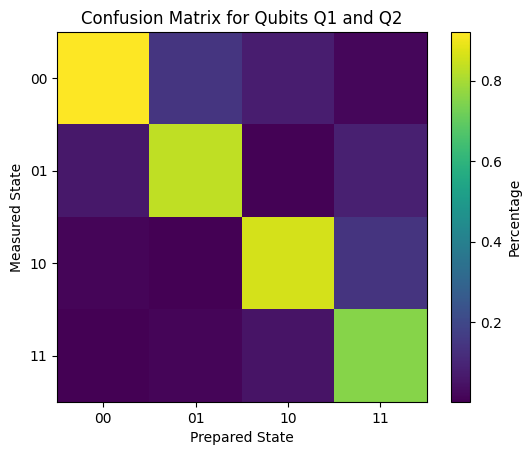

[[0.9196 0.1888 0.0732 0.0152]
 [0.0468 0.7776 0.0122 0.089 ]
 [0.032  0.0044 0.8776 0.1178]
 [0.0016 0.0292 0.037  0.778 ]]


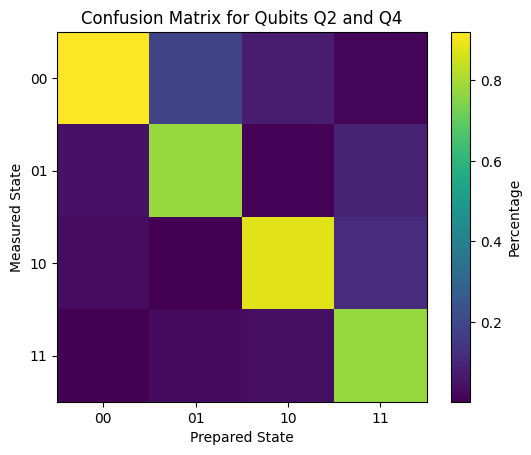

[[0.9414 0.1368 0.058  0.0072]
 [0.0402 0.8464 0.0026 0.064 ]
 [0.0174 0.0018 0.904  0.129 ]
 [0.001  0.015  0.0354 0.7998]]


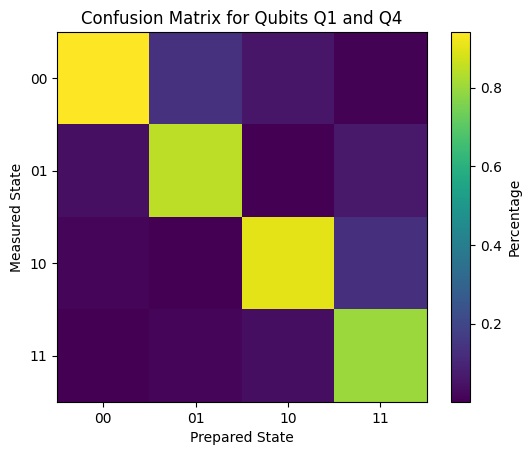

[[9.492e-01 6.560e-02 7.180e-02 1.000e-02]
 [3.220e-02 9.176e-01 2.600e-03 6.760e-02]
 [1.780e-02 1.400e-03 8.940e-01 7.300e-02]
 [8.000e-04 1.540e-02 3.160e-02 8.494e-01]]


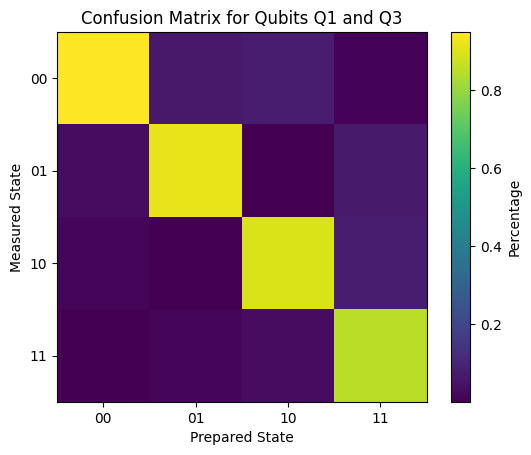

[[0.8942 0.0616 0.1576 0.0432]
 [0.03   0.8134 0.0056 0.1246]
 [0.0726 0.0202 0.8066 0.177 ]
 [0.0032 0.1048 0.0302 0.6552]]


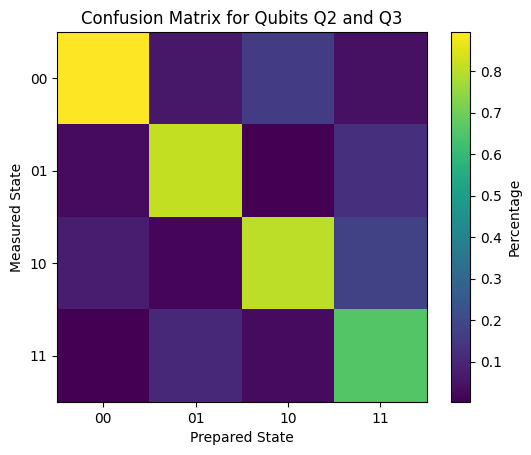

[[0.9424 0.1034 0.0792 0.031 ]
 [0.0242 0.8588 0.0198 0.0836]
 [0.0322 0.0046 0.885  0.0856]
 [0.0012 0.0332 0.016  0.7998]]


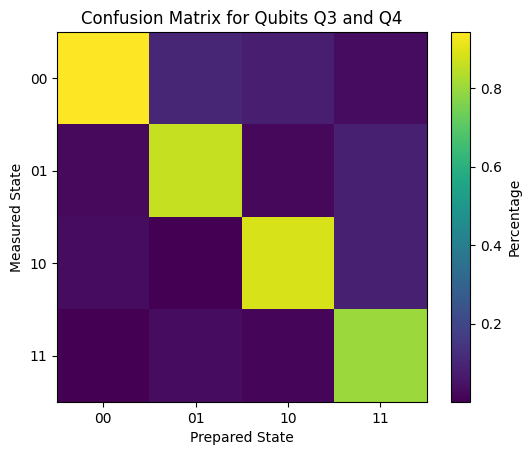

In [8]:
### load in singleshot data


importlib.reload(src.src_singleshot_measurement);
from src.src_singleshot_measurement import Singleshot_2Q_Measurement, Singleshot_1Q_Measurement, generate_singleshot_2Q_filename, generate_singleshot_1Q_filename


singleshot_filename_dict = {}
# single qubit
# singleshot_filenames[0] = generate_singleshot_1Q_filename('2025', '07', '25', '14', '10', '45')
# singleshot_filenames[1] = generate_singleshot_1Q_filename('2025', '07', '25', '14', '11', '22')
# singleshot_filenames[2] = generate_singleshot_1Q_filename('2025', '07', '25', '14', '11', '44')
# singleshot_filenames[3] = generate_singleshot_1Q_filename('2025', '07', '25', '14', '12', '02')

# two qubits
singleshot_filename_dict[(0,1)] = generate_singleshot_2Q_filename('2025', '08', '03', '13', '48', '13')
singleshot_filename_dict[(1,3)] = generate_singleshot_2Q_filename('2025', '08', '02', '13', '04', '03')
singleshot_filename_dict[(0,3)] = generate_singleshot_2Q_filename('2025', '08', '03', '17', '44', '32')
singleshot_filename_dict[(0,2)] = generate_singleshot_2Q_filename('2025', '08', '03', '17', '45', '32')
singleshot_filename_dict[(1,2)] = generate_singleshot_2Q_filename('2025', '08', '03', '18', '14', '01')
singleshot_filename_dict[(2,3)] = generate_singleshot_2Q_filename('2025', '08', '08', '16', '11', '23')

singleshot_measurements = {}
for key in singleshot_filename_dict:

    if isinstance(key, tuple) and len(key) == 2:
        pair = key

        filename = singleshot_filename_dict[pair]
        singleshot_measurement = Singleshot_2Q_Measurement(filename, f'Q{pair[0]+1}', f'Q{pair[1]+1}')
        singleshot_measurements[pair] = singleshot_measurement
    elif isinstance(key, int):
        filename = singleshot_filename_dict[key]
        singleshot_measurement = Singleshot_1Q_Measurement(filename, f'Q{key+1}')
        singleshot_measurements[key] = singleshot_measurement

    print(singleshot_measurement.get_confusion_matrix())
    singleshot_measurements[key].plot_confusion_matrix()
    

#### 1.1.2 Load Current Correlation Data

In [25]:
import correlation_measurements.src_correlation_measurement
importlib.reload(correlation_measurements.src_correlation_measurement)

from correlation_measurements.src_correlation_measurement import RampOscillationShotsMeasurement, generate_ramp_oscillation_population_shots_filename


# assume readout indices are 0,1 and 2,3 for all of these

time_offset = [0, 0, -15, -15 ]
time_offset = [0, 0, 4, 4]
time_offset = 0

state_to_filename = {}

# 8/18/25
# state_to_filename['CD_0_phase1'] = generate_ramp_beamsplitter_correlations_filename('2025', '08', '18', '19', '11', '00')
# state_to_filename['D_0_phase1'] = generate_ramp_beamsplitter_correlations_filename('2025', '08', '18', '22', '08', '36')


# 8/20/25
# state_to_filename['CD_0_phase2'] = generate_ramp_double_jump_correlations_filename('2025', '08', '20', '17', '00', '22')
# state_to_filename['D_0_phase2'] = generate_ramp_double_jump_correlations_filename('2025', '08', '20', '16', '09', '15')
# state_to_filename['D_0_phase2'] = generate_ramp_double_jump_correlations_filename('2025', '08', '20', '16', '28', '30')


# 8/25/25
# state_to_filename['CD_0_phase1'] = generate_ramp_beamsplitter_correlations_filename('2025', '08', '25', '16', '01', '55')


# 8/27/25
# state_to_filename['CD_0_phase1'] = generate_ramp_beamsplitter_correlations_filename('2025', '08', '27', '17', '49', '51')

# 8/29/25
# state_to_filename['CD_0_phase1'] = generate_ramp_double_jump_correlations_filename('2025', '08', '29', '12', '10', '34')

# 9/4/25
# state_to_filename['HHHH_d1'] = generate_ramp_double_jump_correlations_filename('2025', '09', '04', '17', '31', '58')
# state_to_filename['H_d1'] = generate_ramp_double_jump_correlations_filename('2025', '09', '04', '17', '42', '29')
# state_to_filename['HHHH_d2'] = generate_ramp_double_jump_correlations_filename('2025', '09', '04', '17', '42', '29')


# 9/6/25
state_to_filename['HH_4Q'] = generate_ramp_double_jump_correlations_filename('2025', '09', '06', '12', '09', '43')
# state_to_filename['HH_5Q'] = generate_ramp_double_jump_correlations_filename('2025', '09', '06', '12', '20', '08')
# state_to_filename['HH_6Q'] = generate_ramp_double_jump_correlations_filename('2025', '09', '06', '12', '23', '38')


# 9/10/25
# state_to_filename['HHH_6Q'] = generate_ramp_double_jump_correlations_filename('2025', '09', '10', '11', '56', '42')

# 9/10/25
# state_to_filename['HHH_6Q'] = generate_ramp_double_jump_correlations_filename('2025', '09', '11', '11', '41', '24') # 3 particles
# state_to_filename['HHH_6Q_45'] = generate_ramp_double_jump_correlations_filename('2025', '09', '04', '23', '03', '01') # 3 particles

# state_to_filename['HH_6Q'] = generate_ramp_double_jump_correlations_filename('2025', '09', '11', '11', '49', '38') # 2 particles
# state_to_filename['HH_4Q'] = generate_ramp_double_jump_correlations_filename('2025', '09', '11', '13', '09', '20') # 3 particles
# state_to_filename['HH_4Q_5678'] = generate_ramp_double_jump_correlations_filename('2025', '09', '05', '16', '02', '48') # 3 particles


# 9/17/25
# state_to_filename['3P6Q_1234'] = generate_ramp_beamsplitter_correlations_filename('2025', '09', '17', '08', '36', '18') # 3 particles
# state_to_filename['3P6Q_1234'] = generate_ramp_beamsplitter_correlations_filename('2025', '09', '17', '10', '58', '54') # implement mux 8
# state_to_filename['3P6Q_1234'] = generate_ramp_beamsplitter_correlations_filename('2025', '09', '17', '11', '02', '23') # implement mux 8

# state_to_filename['3P6Q_1245'] = generate_ramp_beamsplitter_correlations_filename('2025', '09', '17', '13', '15', '23') # 12-45
# state_to_filename['3P6Q_1245'] = generate_ramp_beamsplitter_correlations_filename('2025', '09', '17', '16', '49', '38') # 12-45


# 9/23/25
state_to_filename['3P6Q_1234'] = generate_ramp_beamsplitter_correlations_filename('2025', '09', '23', '11', '20', '51') # 3 particles
state_to_filename['3P6Q_1254'] = generate_ramp_beamsplitter_correlations_filename('2025', '09', '23', '11', '53', '05') # 12-54
state_to_filename['3P6Q_1256'] = generate_ramp_beamsplitter_correlations_filename('2025', '09', '23', '13', '12', '23') # 12-56

state_to_filename['3P6Q_1234'] = generate_ramp_beamsplitter_correlations_filename('2025', '09', '23', '13', '57', '30') # 12 34 56 longer time
state_to_filename['3P6Q_1254'] = generate_ramp_beamsplitter_correlations_filename('2025', '09', '23', '14', '03', '04') # 12-54
state_to_filename['3P6Q_1254'] = generate_ramp_beamsplitter_correlations_filename('2025', '09', '23', '14', '52', '15') # 12-54

# 9/23/25 - 8Q
state_to_filename['4P8Q_1234'] = generate_ramp_beamsplitter_correlations_filename('2025', '09', '23', '20', '03', '50')
state_to_filename['4P8Q_1234'] = generate_ramp_beamsplitter_correlations_filename('2025', '09', '24', '00', '26', '40')
state_to_filename['4P8Q_1254'] = generate_ramp_beamsplitter_correlations_filename('2025', '09', '23', '23', '14', '12')


# 9/24/25 - 8Q
state_to_filename['4P8Q_1234'] = generate_ramp_beamsplitter_correlations_filename('2025', '09', '24', '16', '53', '27')
state_to_filename['4P8Q_1254'] = generate_ramp_beamsplitter_correlations_filename('2025', '09', '24', '16', '59', '42')

# 9/29/25 - 8Q
state_to_filename['4P8Q_1234'] = generate_ramp_beamsplitter_correlations_filename('2025', '09', '29', '16', '06', '09')


state_to_correlation_measurement = {}

for state in state_to_filename:
    filename = state_to_filename[state]
    state_to_correlation_measurement[state] = RampOscillationShotsMeasurement(filename, singleshot_measurements)
    

Processing state 4P8Q_1234 with beamsplitter time 18.55 ns


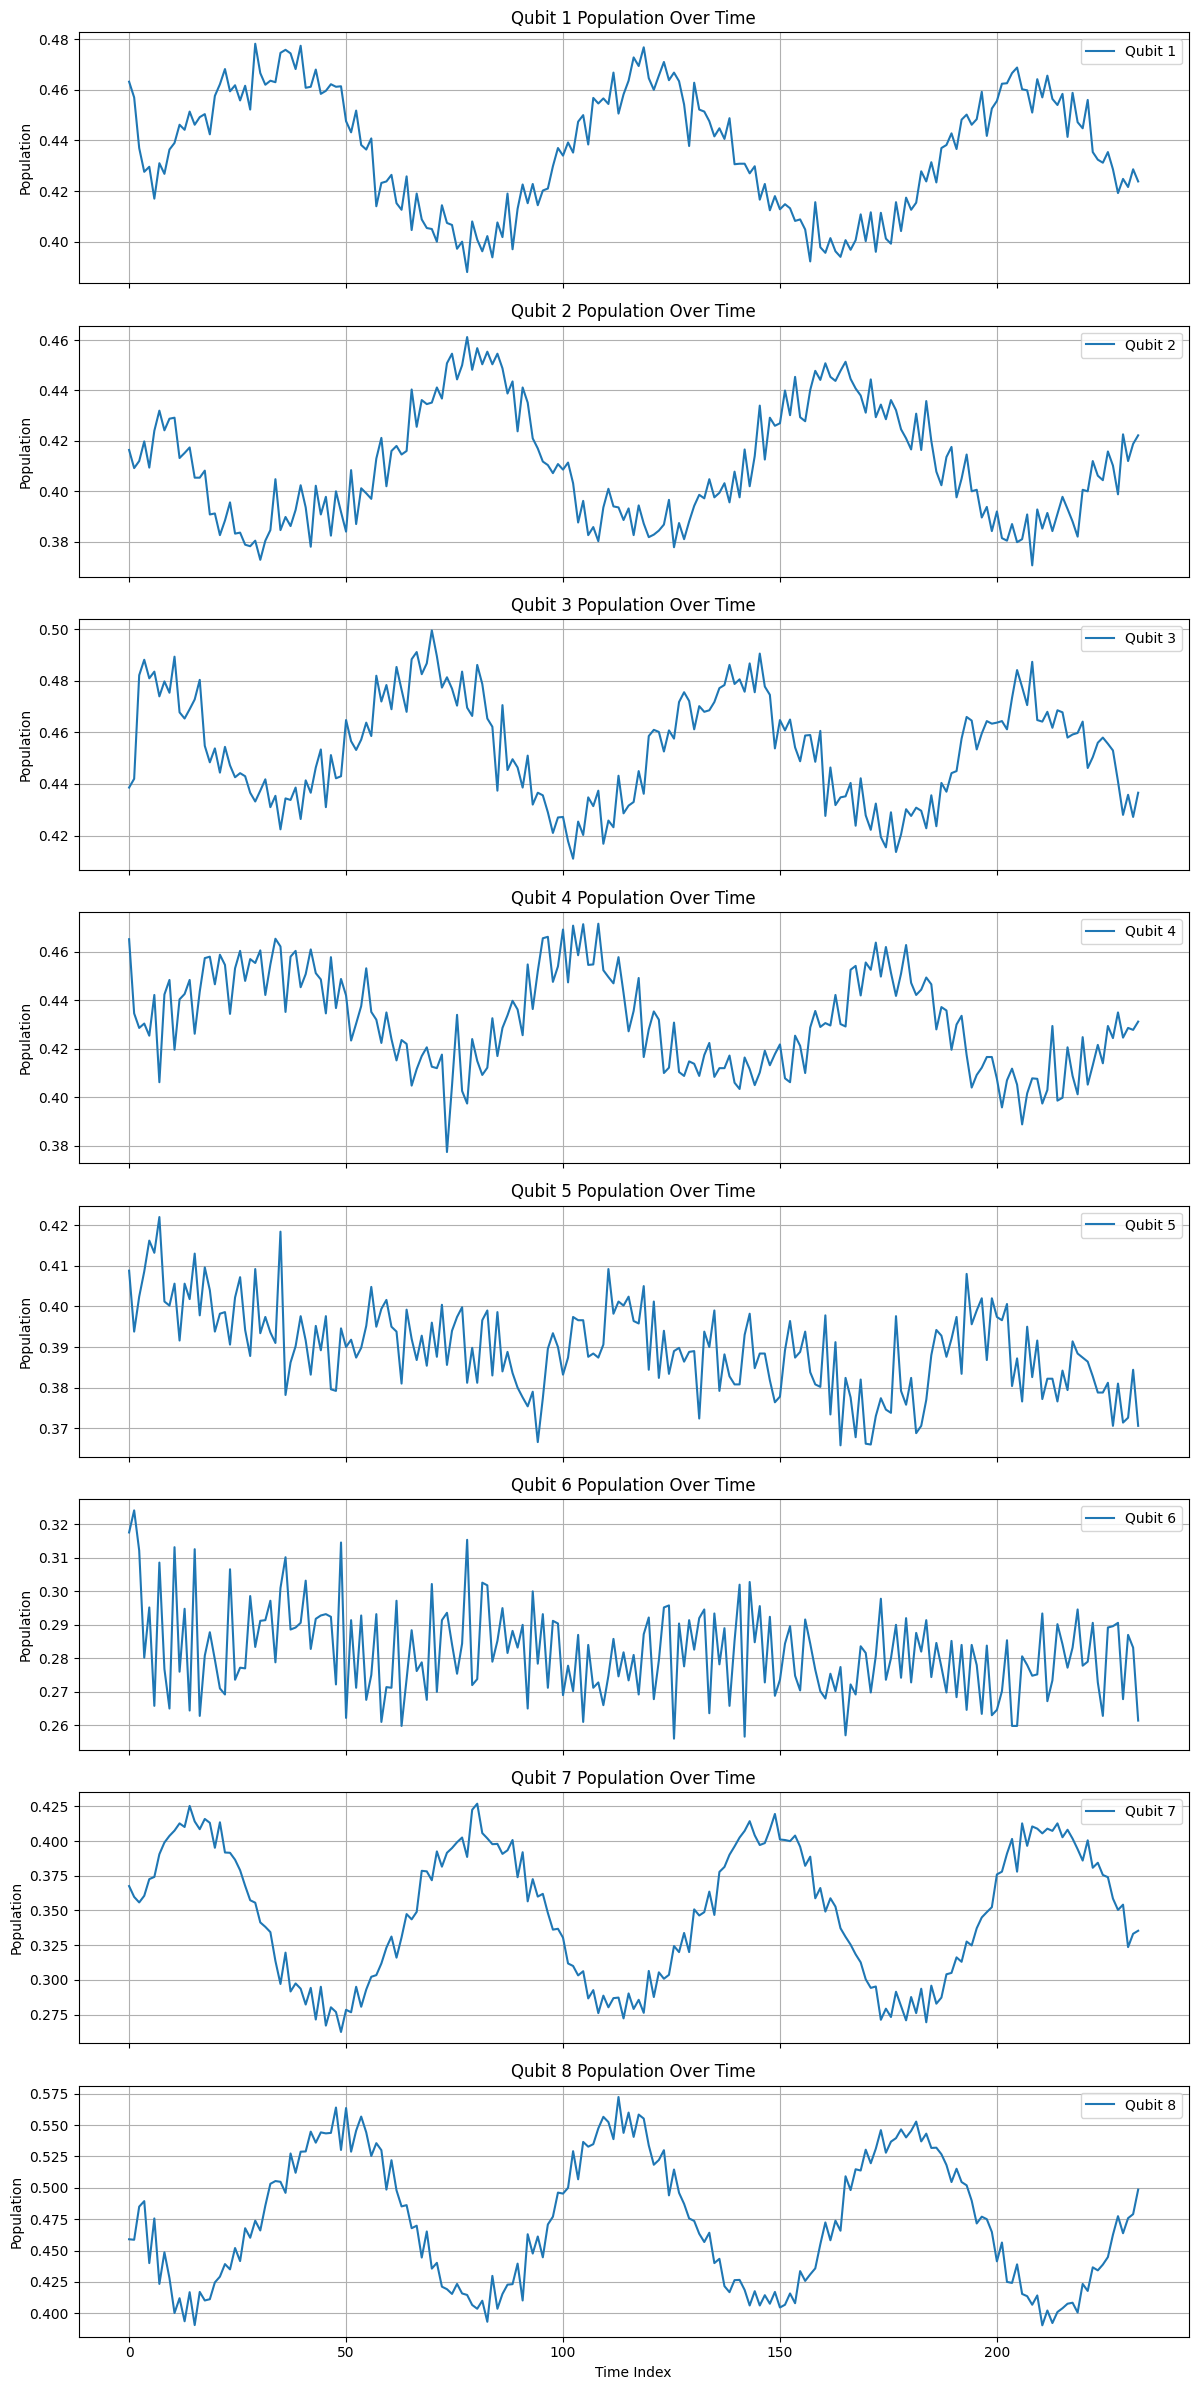

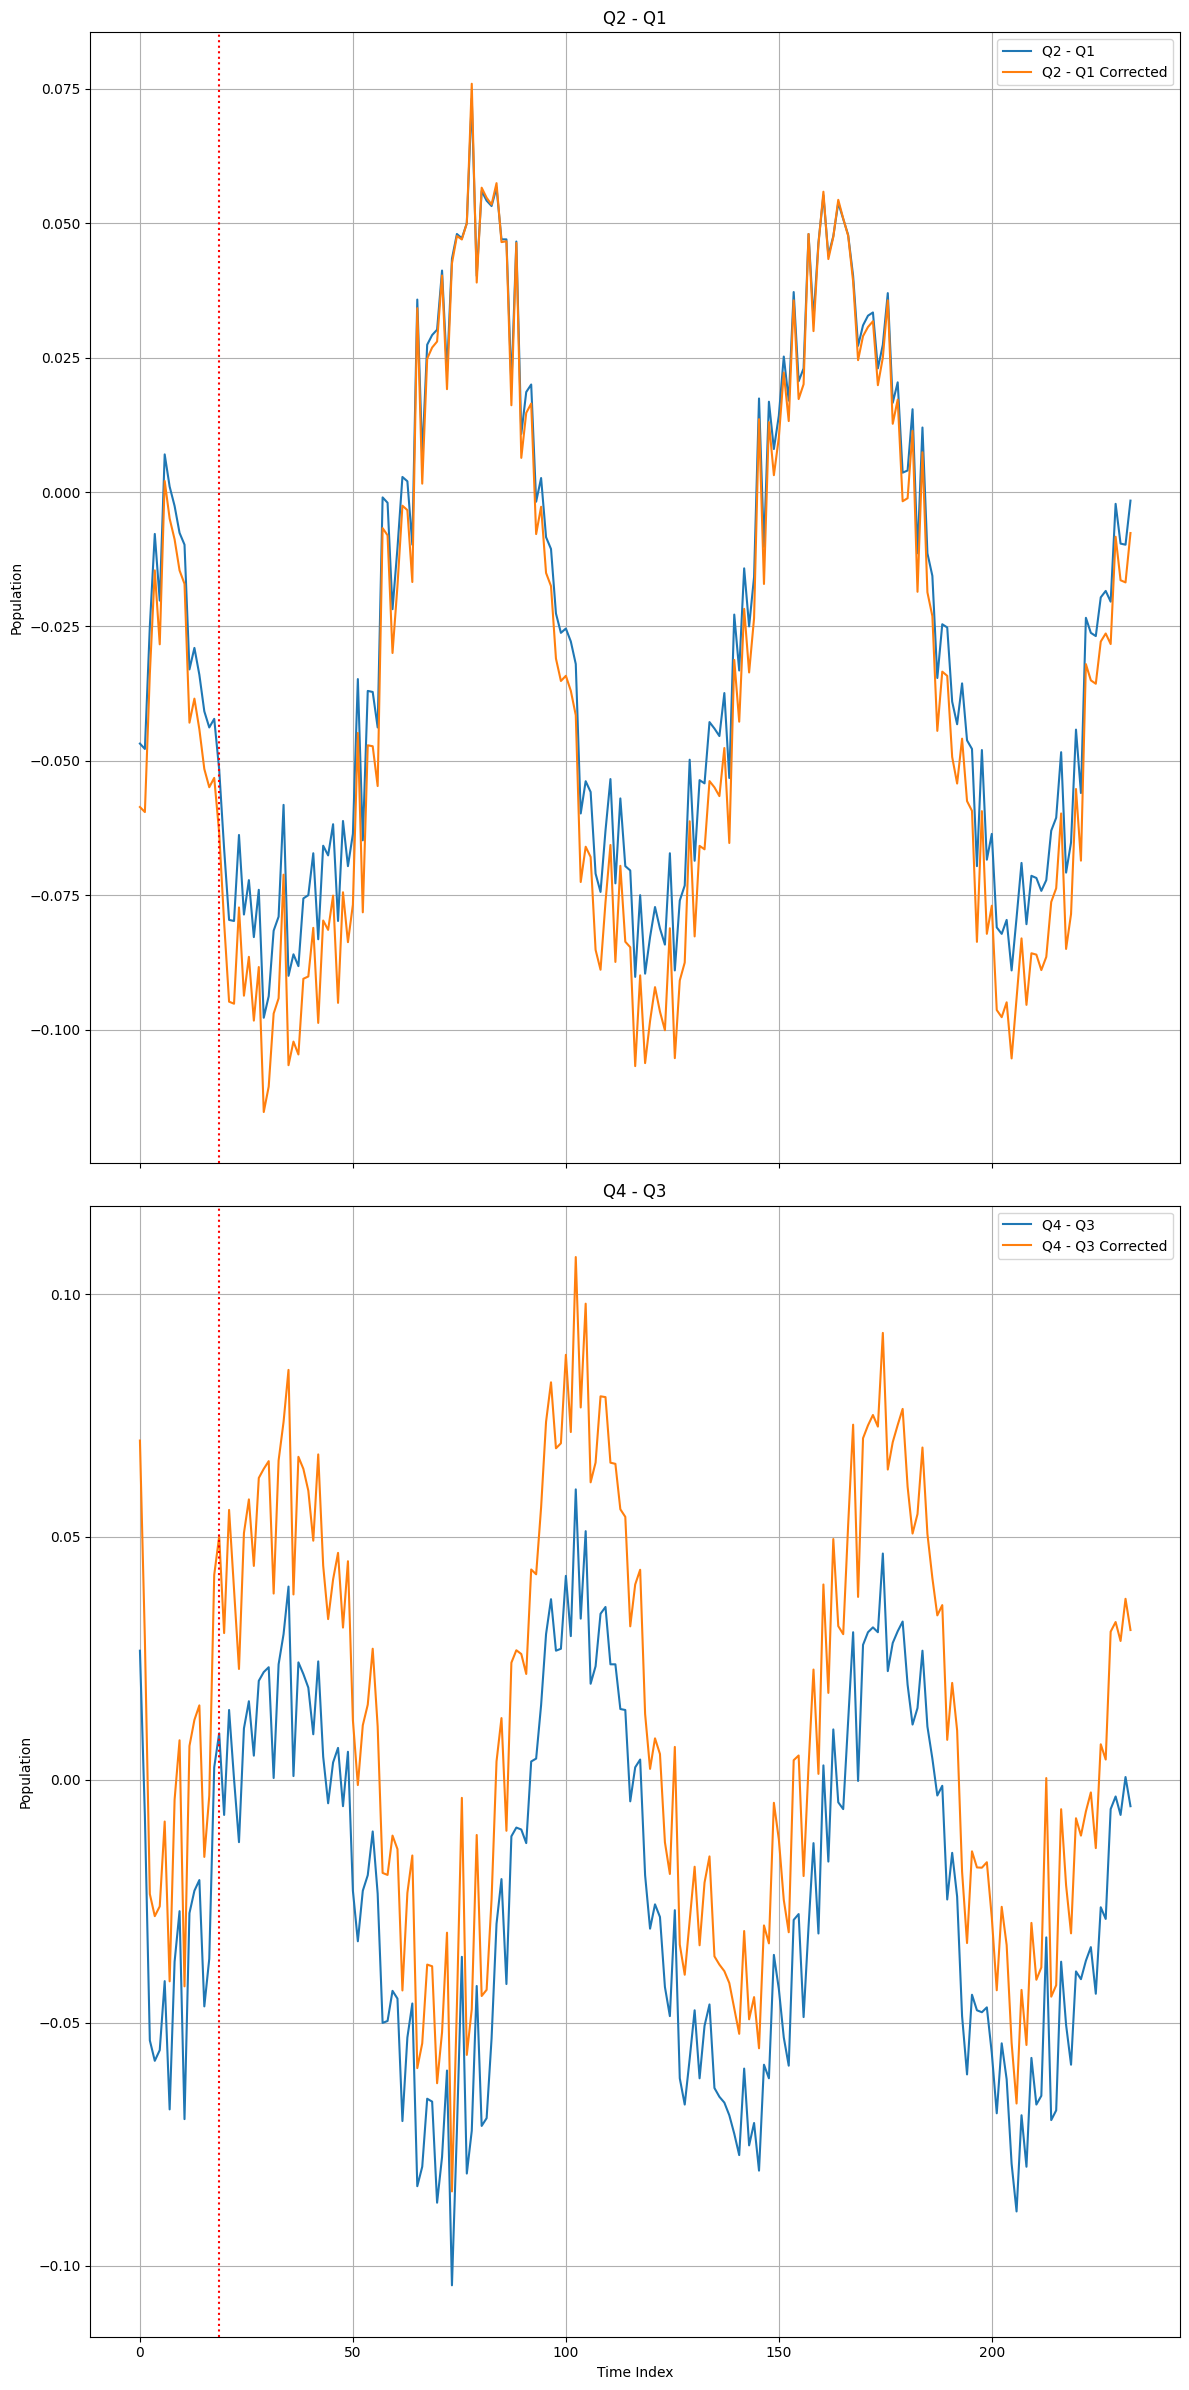

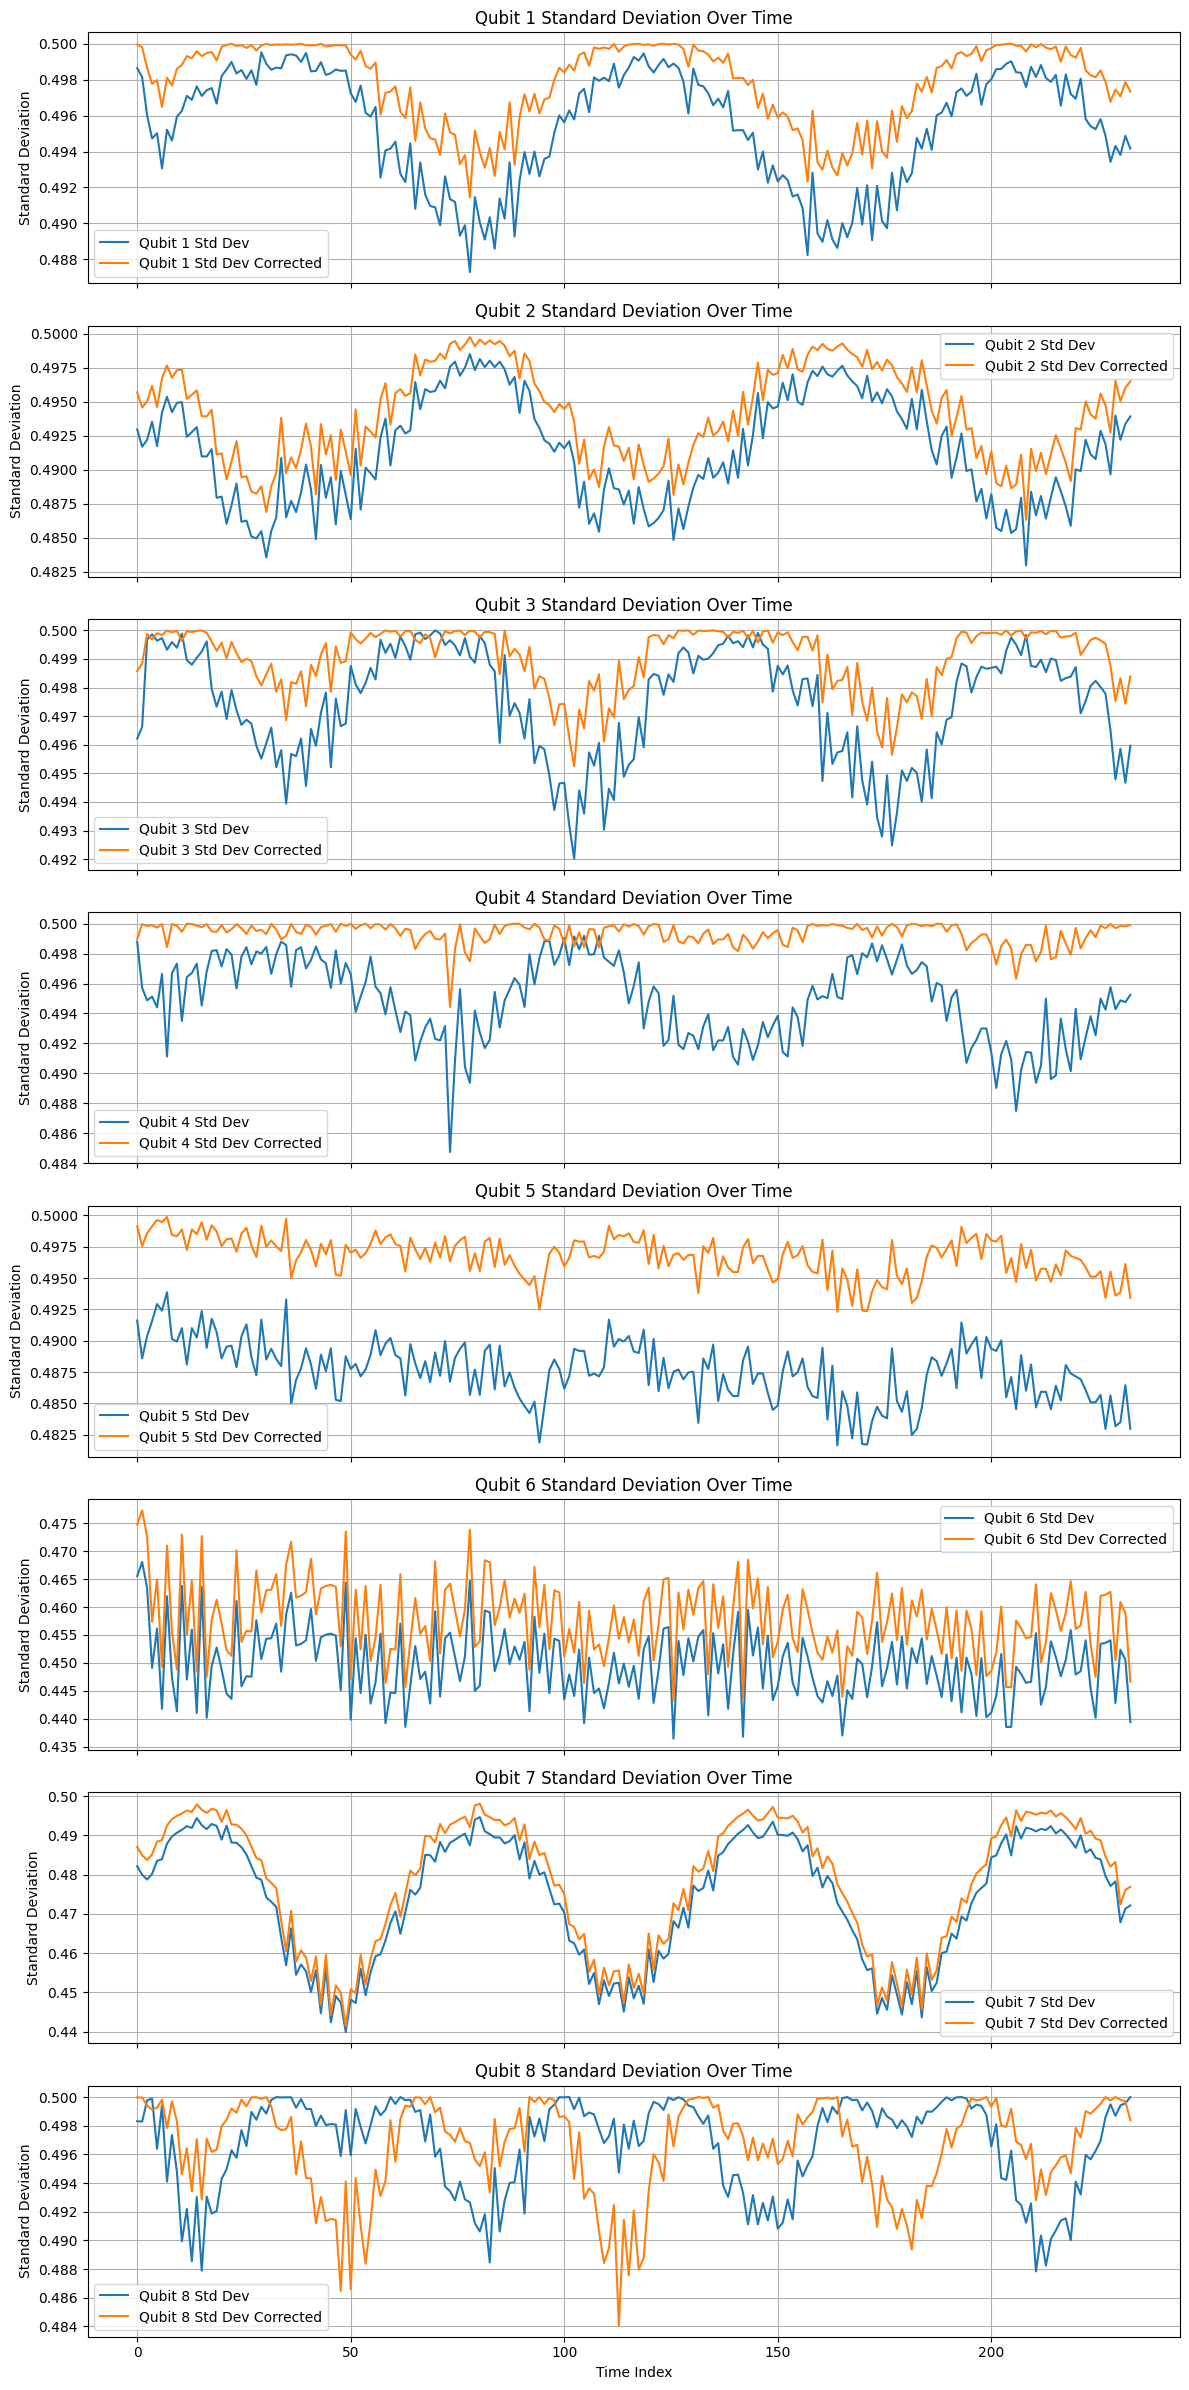

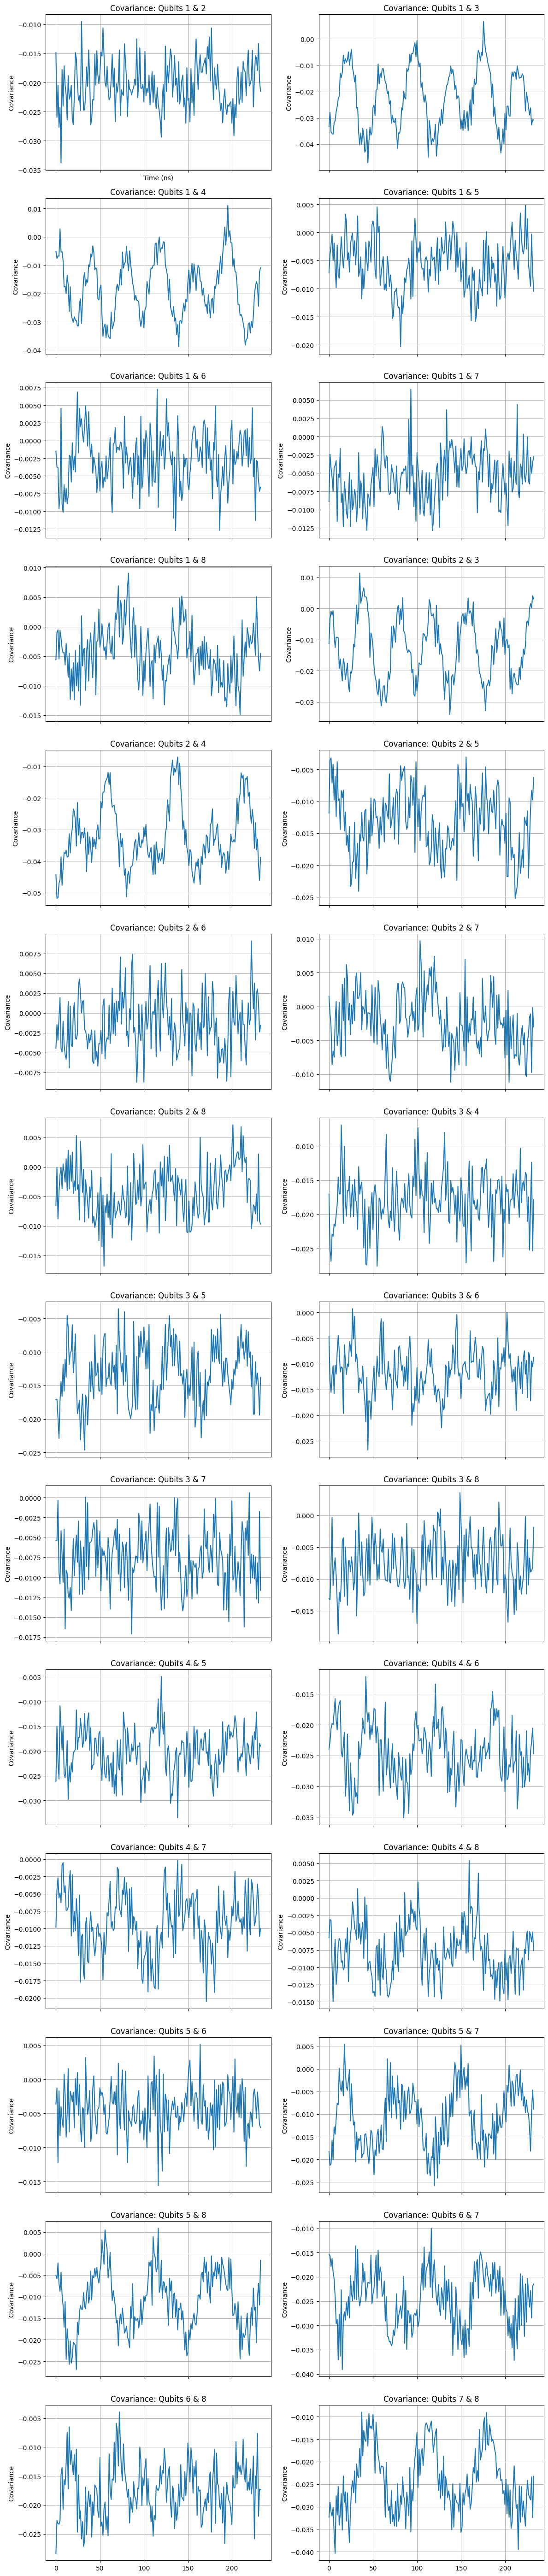

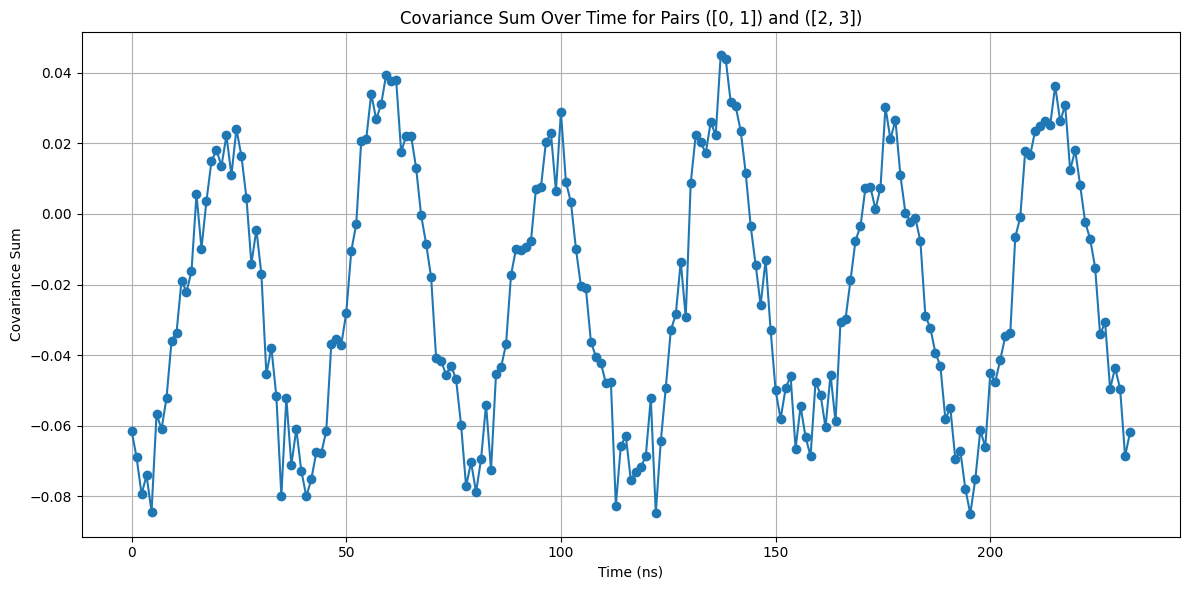

In [10]:
plot_data = True
# plot_data = False

plot_states = None
plot_states = ['4P8Q_1234']  

readout_pair_1 = [0, 1]
readout_pair_2 = [2, 3]
# readout_pair_2 = [4, 3]
readout_pairs = [readout_pair_1, readout_pair_2]

J_guess = 6.74 * 2 * np.pi
beamsplitter_time = J_to_beamsplitter_time(J_guess)

if plot_data:

    for state in state_to_correlation_measurement:

        if plot_states is not None and state not in plot_states:
            continue

        print(f"Processing state {state} with beamsplitter time {beamsplitter_time:.2f} ns")
        # state_to_calibration_measurement[state].plot_population_average(both=True, plot_sum=True)
        state_to_correlation_measurement[state].plot_population(plot_sum=False)
        state_to_correlation_measurement[state].plot_population_difference(readout_pairs, both=True, beamsplitter_time=beamsplitter_time)

        # state_to_correlation_measurement[state].plot_counts()

        state_to_correlation_measurement[state].plot_standard_deviation(both=True)
        # state_to_correlation_measurement[state].plot_covariance(both=True)
        state_to_correlation_measurement[state].plot_covariance()
        
        # state_to_correlation_measurement[state].plot_n_terms(both=True, beamsplitter_time=beamsplitter_time)

        # state_to_correlation_measurement[state].plot_covariance_sum([0,1], [2,3], both=True)
        state_to_correlation_measurement[state].plot_covariance_sum(readout_pair_1, readout_pair_2)

        print()

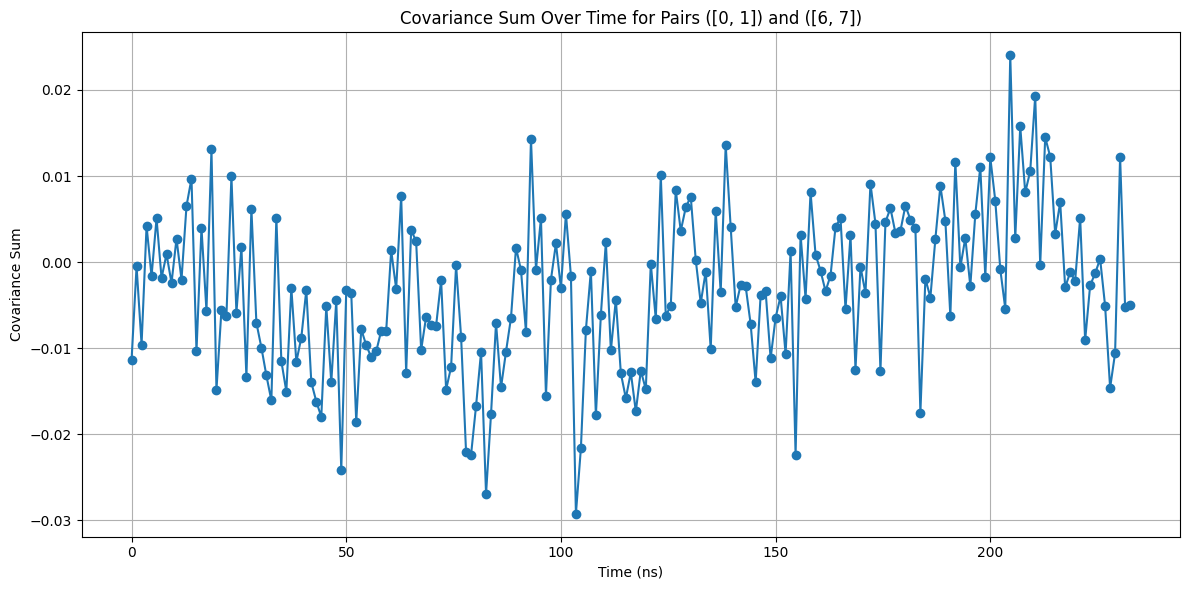

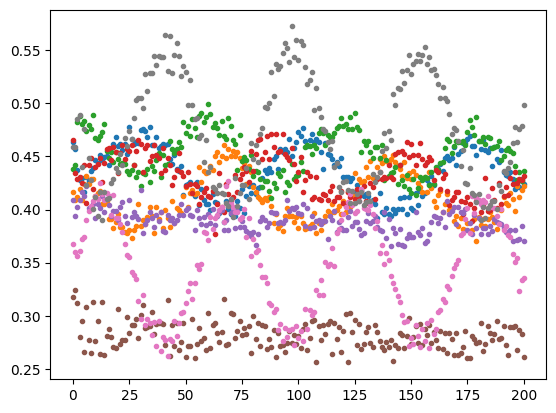

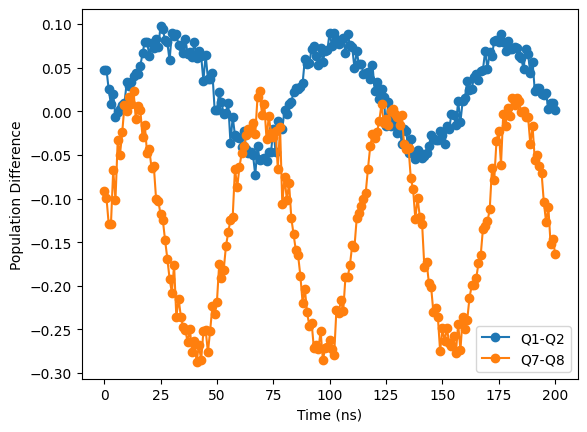

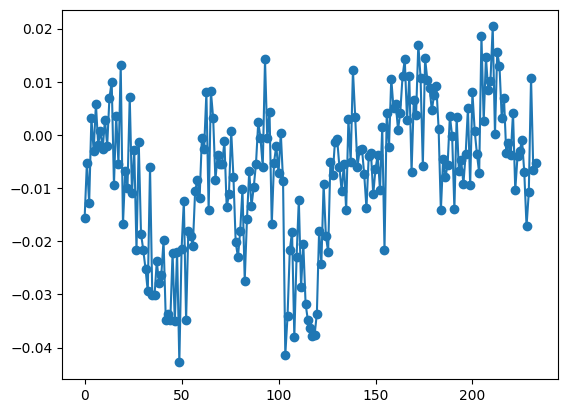

In [11]:
state = '4P8Q_1234'
# state = '4P8Q_1254'

readout_pair_1 = [0, 1]
readout_pair_2 = [2, 3]
# readout_pair_2 = [4, 3]
readout_pair_2 = [4, 5]
# readout_pair_2 = [6, 5]
readout_pair_2 = [6, 7]

measurement = state_to_correlation_measurement[state]
measurement.plot_covariance_sum(readout_pair_1, readout_pair_2, corrected=False)


population_shots = measurement.get_population_shots()
for i in range(8):
    plt.plot(np.mean(population_shots[i,:,:], axis=-1), '.')
plt.show()

population_diff_1 = population_shots[readout_pair_1[0], :, :] - population_shots[readout_pair_1[1], :, :]
population_diff_2 = population_shots[readout_pair_2[0], :, :] - population_shots[readout_pair_2[1], :, :]

plt.plot(np.mean(population_diff_1, axis=-1), 'o-', label=f'Q{readout_pair_1[0]+1}-Q{readout_pair_1[1]+1}')
plt.plot(np.mean(population_diff_2, axis=-1), 'o-', label=f'Q{readout_pair_2[0]+1}-Q{readout_pair_2[1]+1}')
plt.xlabel('Time (ns)')
plt.ylabel('Population Difference')
plt.legend()
plt.show()

correlation_sum = np.mean(population_diff_1 * population_diff_2, axis=-1)
times = measurement.get_times()

plt.plot(times, correlation_sum, 'o-')

### 1.2 Fit Populations

In [26]:
state = '4P8Q_1234'
# state = '3P6Q_1234'
# state = 'D_0_phase1'
state = 'HH_4Q'

measurement = state_to_correlation_measurement[state]
# populations_data = measurement.get_population_average()
populations_data = measurement.get_population_corrected()

initial_state_counts = measurement.get_counts()[:,0]

#### 1.2.1 Parameters and Initial Guess

In [27]:
### 4 qubits

importlib.reload(src.src_current_measurement_fits)
from src.src_current_measurement_fits import calculate_populations_simulation

num_levels = 3
num_qubits = 4

# 0 flux
J = -np.array([5.75, 6.39, 6.61]) * 2 * np.pi # MHz
J_parallel = np.array([6.78, 7.21]) * 2 * np.pi # MHz

# pi flux
# J = -np.array([6.26, 5.9, 5.95]) * 2 * np.pi # MHz
# J_parallel = -np.array([7.25, 7.65]) * 2 * np.pi # MHz


initial_detunings = np.array([0, 0, 0, 0]) * 2 * np.pi # MHz
psi0_angles = [np.pi, 0, np.pi, 0]  # theta_1, phi_1, theta_2, phi_2
scale_factor = 1.0



measurement_J = -np.array([6.96, 5.9, 5.88]) * 2 * np.pi # MHz
measurement_J = -np.array([6.96, 5.9, 6.5]) * 2 * np.pi # MHz
# measurement_J = -np.array([6.96, 5.9, 6.2]) * 2 * np.pi # MHz
measurement_J_parallel = J_parallel.copy()

measurement_detuning = np.array([300, 300, -300, -300]) * 2 * np.pi  # MHz
# measurement_detuning = np.array([300, 300, -300, -302]) * 2 * np.pi  # MHz


U = -180 * 2 * np.pi

T1 = 200  # 40 microseconds
T2 = 10  # 5 microseconds

# T1 = None
# T2 = None


# use the times from the measurement and convert to microseconds
times = measurement.get_times() * 1e-3  # Time in microseconds

readout_pair_1 = [0, 1]
readout_pair_2 = [2, 3]


### modify initial state

modify_psi0_kwargs = {}

modify_psi0_kwargs['add_phase'] = True
modify_psi0_kwargs['pairs'] = [readout_pair_1, readout_pair_2]
phases = [0.0, 0.0]

modify_psi0_kwargs['add_x_rotation'] = True
modify_psi0_kwargs['x_pairs'] = [readout_pair_1, readout_pair_2]
x_angles = [0.0, 0.0]


if state == 'CD_0_phase1':
    psi0 = -1
    num_particles = 2
    psi0_bitstring = '1001'

    modify_psi0_kwargs['add_phase'] = True
    # modify_psi0_kwargs['phases'] = [0.6446500386687627, 0.3685980233648204]

    phases = [0.9002599520018123, 0.059786535463969344]
    # phases = [0.9002599520018123, 0.159786535463969344]
    phases = [0.2, -0.1]

 
    modify_psi0_kwargs['add_x_rotation'] = True
    x_angles = [-3*np.pi/4, -3*np.pi/4]

    scale_factor = 0.8


    # without phase suppression
    J = [-36.10578025741489, -40.115459753793374, -41.551226601701636]
    J_parallel = [42.58836841278678, 45.32400457908101]
    initial_detunings = [0.008282350141784498, -0.018142103269883546, 0.0014769944815681733, 0.03555081053551961]
    phases = [0.2522289596836303, -0.2981070283065213]
    phases = [0, 0]
    x_angles = [0.015094402968233571, -0.009952880035159546]
    measurement_J = [-43.732643474294704, -37.070691004684875, -37.70794168867912]

    # with phase suppresion
    # J = [-36.12831350196473, -40.14955439304585, -41.53185213234491]
    # J_parallel = [42.59999840699874, 45.30176785967679]
    # initial_detunings = [6.425063543959923e-07, 7.132601648241254e-07, 2.933625992953357e-06, 2.696348830377476e-06]
    # phases = [0.19999975942745035, -0.0999998993833463]
    # x_angles = [-2.3561944818220653, -2.3561944798272445]

    # J = [-36.12831350196473, -40.14955439304585, -41.53185213234491]
    # J_parallel = [42.59999840699874, 45.30176785967679]
    # initial_detunings = [6.425063543959923e-07, 7.132601648241254e-07, 2.933625992953357e-06, 2.696348830377476e-06]
    # phases = [0.375266186579948, -0.02540897360777037]
    # x_angles = [-1.9937180547481321, -0.6747573269780808]

    modify_psi0_kwargs['use_mixed_state'] = False
    print(modify_psi0_kwargs['use_mixed_state'])

    modify_psi0_kwargs['pre_ramp_detuning'] = np.array([100, -100, -105, 0])
    modify_psi0_kwargs['basis_state_to_index_dict'] = create_basis_state_to_index_mapping(num_levels, num_qubits, modify_psi0_kwargs['pre_ramp_detuning'], U)



    modify_psi0_kwargs['mixed_basis_states'] = ['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
    modify_psi0_kwargs['mixed_probabilities'] = [0.014, 0.0794, 0.0038, 0.0104, 0.0092, 0.0144, 0.001, 0.0002, 0.0994, 0.705, 0.0154, 0.031, 0.0082, 0.0076, 0.0006, 0.0004]

    modify_psi0_kwargs['use_mixed_ramp'] = False
    modify_psi0_kwargs['mixed_probabilities'] = initial_state_counts / np.sum(initial_state_counts)



elif state == 'CD_0_phase2':
    psi0 = -1
    num_particles = 2
    psi0_bitstring = '1001'

    modify_psi0_kwargs['add_phase'] = True
    # initial_detunings = [1.6487278690604081, -21.84594354013756, -18.53794600081936, -6.2282654509220325]
    modify_psi0_kwargs['phases'] = [3.1415925586617526, 3.141592653589793]

    modify_psi0_kwargs['add_x_rotation'] = True
    modify_psi0_kwargs['x_angles'] = [0, 0]


    scale_factor = 1

    modify_psi0_kwargs['use_mixed_state'] = False
    print(modify_psi0_kwargs['use_mixed_state'])

    modify_psi0_kwargs['pre_ramp_detuning'] = np.array([100, -100, -105, 0])
    modify_psi0_kwargs['basis_state_to_index_dict'] = create_basis_state_to_index_mapping(num_levels, num_qubits, modify_psi0_kwargs['pre_ramp_detuning'], U)


    modify_psi0_kwargs['mixed_basis_states'] = ['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
    modify_psi0_kwargs['mixed_probabilities'] = [0.014, 0.0794, 0.0038, 0.0104, 0.0092, 0.0144, 0.001, 0.0002, 0.0994, 0.705, 0.0154, 0.031, 0.0082, 0.0076, 0.0006, 0.0004]
     
elif state == 'BD':
    psi0 = -2
    num_particles = 2
    psi0_bitstring = '1100'
elif state == 'BC':
    psi0 = -3
    num_particles = 2
    psi0_bitstring = '0101'
elif state == 'D_0_phase1':
    psi0 = -1
    num_particles = 1
    psi0_bitstring = '0001'

    J = [-36.12831544269876, -40.149554031103314, -41.531854795868306]
    J_parallel = [42.59999629589693, 45.30176615690193]
    initial_detunings = [1.279717479493422e-07, 1.279710315202759e-07, -1.2801657226147148e-07, -1.2800335183751435e-07]
    modify_psi0_kwargs['phases'] = [0.7853981621070993, 0.3926990792515008]


elif state == 'A':
    psi0 = 0
    num_particles = 1
    psi0_bitstring = '1000'
elif state == 'B':
    psi0 = 1
    num_particles = 1
    psi0_bitstring = '0100'

elif state == 'HH_4Q':
    psi0 = -1
    num_particles = 2
    psi0_bitstring = '1001'

    modify_psi0_kwargs['add_phase'] = True
    # modify_psi0_kwargs['phases'] = [0.6446500386687627, 0.3685980233648204]

    phases = [0.9002599520018123, 0.059786535463969344]
    # phases = [0.9002599520018123, 0.159786535463969344]
    phases = [0.2, -0.1]

 
    modify_psi0_kwargs['add_x_rotation'] = True
    x_angles = [-3*np.pi/4, -3*np.pi/4]

    scale_factor = 0.8


    # without phase suppression
    J = [-36.10578025741489, -40.115459753793374, -41.551226601701636]
    J_parallel = [42.58836841278678, 45.32400457908101]
    initial_detunings = [0.008282350141784498, -0.018142103269883546, 0.0014769944815681733, 0.03555081053551961]
    phases = [0.2522289596836303, -0.2981070283065213]
    phases = [0, 0]
    x_angles = [0.015094402968233571, -0.009952880035159546]
    measurement_J = [-43.732643474294704, -37.070691004684875, -37.70794168867912]

    # with phase suppresion
    # J = [-36.12831350196473, -40.14955439304585, -41.53185213234491]
    # J_parallel = [42.59999840699874, 45.30176785967679]
    # initial_detunings = [6.425063543959923e-07, 7.132601648241254e-07, 2.933625992953357e-06, 2.696348830377476e-06]
    # phases = [0.19999975942745035, -0.0999998993833463]
    # x_angles = [-2.3561944818220653, -2.3561944798272445]

    # J = [-36.12831350196473, -40.14955439304585, -41.53185213234491]
    # J_parallel = [42.59999840699874, 45.30176785967679]
    # initial_detunings = [6.425063543959923e-07, 7.132601648241254e-07, 2.933625992953357e-06, 2.696348830377476e-06]
    # phases = [0.375266186579948, -0.02540897360777037]
    # x_angles = [-1.9937180547481321, -0.6747573269780808]

    modify_psi0_kwargs['use_mixed_state'] = False
    print(modify_psi0_kwargs['use_mixed_state'])

    modify_psi0_kwargs['pre_ramp_detuning'] = np.array([100, -100, -105, 0])
    modify_psi0_kwargs['basis_state_to_index_dict'] = create_basis_state_to_index_mapping(num_levels, num_qubits, modify_psi0_kwargs['pre_ramp_detuning'], U)



    modify_psi0_kwargs['mixed_basis_states'] = ['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
    modify_psi0_kwargs['mixed_probabilities'] = [0.014, 0.0794, 0.0038, 0.0104, 0.0092, 0.0144, 0.001, 0.0002, 0.0994, 0.705, 0.0154, 0.031, 0.0082, 0.0076, 0.0006, 0.0004]

    modify_psi0_kwargs['use_mixed_ramp'] = True
    modify_psi0_kwargs['mixed_probabilities'] = initial_state_counts / np.sum(initial_state_counts)



# if True, use uncoupled Hamiltonian for beamsplitter simulation
# uncoupled = True
uncoupled = False


modify_psi0_kwargs['phases'] = phases

modify_psi0_kwargs['x_angles'] = x_angles

print(modify_psi0_kwargs['phases'])
print(modify_psi0_kwargs['x_pairs'])

populations_simulation = calculate_populations_simulation(num_levels, num_qubits, num_particles, J, J_parallel, U, times, readout_pair_1, 
                                                  readout_pair_2, initial_detunings, measurement_detuning, psi0=psi0,
                                                  measurement_J=measurement_J, measurement_J_parallel=measurement_J_parallel,
                                                  scale_factor=scale_factor, T1=T1, T2=T2, print_logs=True, uncoupled=uncoupled, **modify_psi0_kwargs)


print(f'cost: {cost_function(populations_data, populations_simulation):.4f}')



False
[0, 0]
[[0, 1], [2, 3]]
__init__
psi0 dims: [[3, 3, 3, 3], [1, 1, 1, 1]]
psi0 is a state vector
initial state before modifying is state vector
creating mixed state after ramp
states: ['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
probabilities: [0.074 0.056 0.128 0.086 0.13  0.042 0.104 0.008 0.08  0.102 0.058 0.018
 0.072 0.014 0.028 0.   ]
adding phase ([0.0, 0.0] pi) to pairs ([[0, 1], [2, 3]])
adding x rotation ([0.005, -0.003] pi) to pairs ([[0, 1], [2, 3]])
initial state after modifying is density matrix
running simulation
psi0 is a density matrix
running mesolve
cost: 7.9167


In [ ]:
### 5 qubits

importlib.reload(src.src_current_measurement_fits)
from src.src_current_measurement_fits import calculate_populations_simulation

num_levels = 3
num_qubits = 5

# pi flux
J = -np.array([6.02, 6.26, 6.01, 6.23, 6.07, 6.36, 6.13])[:4] * 2 * np.pi # MHz
J_parallel = -np.array([7.08, 7.33, 7.30, 7.70, 7.26, 7.01])[:3] * 2 * np.pi # MHz


initial_detunings = np.array([0, 0, 0, 0, 0]) * 2 * np.pi # MHz



measurement_J = J.copy()
measurement_J_parallel = J_parallel.copy()
measurement_detuning = np.array([550, 550, -100, -100, 200, 200, 200, 200])[:5] * 2 * np.pi  # MHz


U = -180 * 2 * np.pi

T1 = 200  # 40 microseconds
T2 = 10  # 5 microseconds

T1 = None
T2 = None


# use the times from the measurement and convert to microseconds
times = measurement.get_times() * 1e-3  # Time in microseconds

readout_pair_1 = [0, 1]
readout_pair_2 = [2, 3]


### modify initial state

modify_psi0_kwargs = {}

modify_psi0_kwargs['add_phase'] = False
modify_psi0_kwargs['pairs'] = [readout_pair_1, readout_pair_2]
modify_psi0_kwargs['phases'] = [0, 0]

modify_psi0_kwargs['add_x_rotation'] = False
modify_psi0_kwargs['x_pairs'] = [readout_pair_1, readout_pair_2]
modify_psi0_kwargs['x_angles'] = [0, 0]


if state == 'HH_5Q':
    psi0 = -1
    num_particles = 2
    psi0_bitstring = '1001'

    modify_psi0_kwargs['add_phase'] = True
    phases = [0, np.pi]

    initial_detunings = [0]*num_qubits



    scale_factor = 1

    modify_psi0_kwargs['add_x_rotation'] = True
    x_angles = [0, np.pi/4]


    modify_psi0_kwargs['use_mixed_state'] = False
    print(modify_psi0_kwargs['use_mixed_state'])

    modify_psi0_kwargs['pre_ramp_detuning'] = np.array([100, -100, -105, 0, -150])
    modify_psi0_kwargs['basis_state_to_index_dict'] = create_basis_state_to_index_mapping(num_levels, num_qubits, modify_psi0_kwargs['pre_ramp_detuning'], U)


    modify_psi0_kwargs['mixed_basis_states'] = ['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
    modify_psi0_kwargs['mixed_probabilities'] = [0.014, 0.0794, 0.0038, 0.0104, 0.0092, 0.0144, 0.001, 0.0002, 0.0994, 0.705, 0.0154, 0.031, 0.0082, 0.0076, 0.0006, 0.0004]

    modify_psi0_kwargs['use_mixed_ramp'] = False
    modify_psi0_kwargs['mixed_probabilities'] = initial_state_counts / np.sum(initial_state_counts)


# if True, use uncoupled Hamiltonian for beamsplitter simulation
# uncoupled = True
uncoupled = False


modify_psi0_kwargs['phases'] = phases
modify_psi0_kwargs['x_angles'] = x_angles

populations_simulation = calculate_populations_simulation(num_levels, num_qubits, num_particles, J, J_parallel, U, times, readout_pair_1, 
                                                  readout_pair_2, initial_detunings, measurement_detuning, psi0=psi0,
                                                  measurement_J=measurement_J, measurement_J_parallel=measurement_J_parallel,
                                                  scale_factor=scale_factor, T1=T1, T2=T2, print_logs=True, uncoupled=uncoupled, return_simulation_object=True,
                                                  **modify_psi0_kwargs)



print(f'cost: {cost_function(populations_data, populations_simulation):.4f}')


False
psi0 dims: [[3, 3, 3, 3, 3], [1, 1, 1, 1, 1]]
psi0 is a state vector
initial state before modifying is state vector
adding phase ([0.0, 1.0] pi) to pairs ([[0, 1], [2, 3]])
adding x rotation ([0.0, 0.25] pi) to pairs ([[0, 1], [2, 3]])
initial state after modifying is state vector
running simulation
running sesolve
cost: 43.6223


In [19]:
### 6 qubits

importlib.reload(src.src_current_measurement_fits)
from src.src_current_measurement_fits import calculate_populations_simulation

num_levels = 3
num_qubits = 6

# pi flux
J = -np.array([6.02, 6.26, 6.01, 6.23, 6.07, 6.36, 6.13])[:num_qubits-1] * 2 * np.pi # MHz
J_parallel = -np.array([7.08, 7.33, 7.30, 7.70, 7.26, 7.01])[:num_qubits-2] * 2 * np.pi # MHz


initial_detunings = np.array([0, 0, 0, 0, 0, 0]) * 2 * np.pi # MHz



measurement_J = J.copy()
measurement_J_parallel = J_parallel.copy()
measurement_detuning = np.array([550, 550, -100, -100, 200, 200, 200, 200])[:num_qubits] * 2 * np.pi  # MHz


U = -180 * 2 * np.pi

T1 = 200  # 40 microseconds
T2 = 10  # 5 microseconds

T1 = None
T2 = None


# use the times from the measurement and convert to microseconds
times = measurement.get_times() * 1e-3  # Time in microseconds

readout_pair_1 = [0, 1]
readout_pair_2 = [2, 3]


### modify initial state

modify_psi0_kwargs = {}

modify_psi0_kwargs['add_phase'] = False
modify_psi0_kwargs['pairs'] = [readout_pair_1, readout_pair_2]
modify_psi0_kwargs['phases'] = [0, 0]

modify_psi0_kwargs['add_x_rotation'] = False
modify_psi0_kwargs['x_pairs'] = [readout_pair_1, readout_pair_2]
modify_psi0_kwargs['x_angles'] = [0, 0]


if state == 'HHH_6Q':
    psi0 = -1
    num_particles = 3
    psi0_bitstring = '100110'

    modify_psi0_kwargs['add_phase'] = True
    phases = [0, 0]

    initial_detunings = [0]*num_qubits

    initial_detunings = np.array([2, 0, 0, 0, 0, 0]) * 2 * np.pi # MHz


    scale_factor = 1

    modify_psi0_kwargs['add_x_rotation'] = True
    x_angles = [0, 0]


    modify_psi0_kwargs['use_mixed_state'] = False
    print(modify_psi0_kwargs['use_mixed_state'])

    modify_psi0_kwargs['pre_ramp_detuning'] = np.array([50, -200, -200, 100, -100, -200])*2*np.pi
    modify_psi0_kwargs['basis_state_to_index_dict'] = create_basis_state_to_index_mapping(num_levels, num_qubits, modify_psi0_kwargs['pre_ramp_detuning'], U)


    modify_psi0_kwargs['mixed_basis_states'] = ['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
    modify_psi0_kwargs['mixed_probabilities'] = [0.014, 0.0794, 0.0038, 0.0104, 0.0092, 0.0144, 0.001, 0.0002, 0.0994, 0.705, 0.0154, 0.031, 0.0082, 0.0076, 0.0006, 0.0004]

    modify_psi0_kwargs['use_mixed_ramp'] = False
    modify_psi0_kwargs['mixed_probabilities'] = initial_state_counts / np.sum(initial_state_counts)


# if True, use uncoupled Hamiltonian for beamsplitter simulation
# uncoupled = True
uncoupled = False


modify_psi0_kwargs['phases'] = phases
modify_psi0_kwargs['x_angles'] = x_angles

populations_simulation = calculate_populations_simulation(num_levels, num_qubits, num_particles, J, J_parallel, U, times, readout_pair_1, 
                                                  readout_pair_2, initial_detunings, measurement_detuning, psi0=psi0,
                                                  measurement_J=measurement_J, measurement_J_parallel=measurement_J_parallel,
                                                  scale_factor=scale_factor, T1=T1, T2=T2, print_logs=True, uncoupled=uncoupled, return_simulation_object=True,
                                                  **modify_psi0_kwargs)



print(f'cost: {cost_function(populations_data, populations_simulation):.4f}')


False
psi0 dims: [[3, 3, 3, 3, 3, 3], [1, 1, 1, 1, 1, 1]]
psi0 is a state vector
initial state before modifying is state vector
adding phase ([0.0, 0.0] pi) to pairs ([[0, 1], [2, 3]])
adding x rotation ([0.0, 0.0] pi) to pairs ([[0, 1], [2, 3]])
initial state after modifying is state vector
running simulation
running sesolve
cost: 17.3139


In [ ]:
### 8 qubits

importlib.reload(src.src_current_measurement_fits)
from src.src_current_measurement_fits import calculate_populations_simulation

num_levels = 4
num_qubits = 8

# pi flux
J = -np.array([6.02, 6.26, 6.01, 6.23, 6.07, 6.36, 6.13]) * 2 * np.pi # MHz
J_parallel = np.array([7.08, 7.33, 7.30, 7.70, 7.26, 7.01]) * 2 * np.pi # MHz


initial_detunings = np.array([0, 0, 0, 0, 0, 0, 0, 0]) * 2 * np.pi # MHz
scale_factor = 1.0



measurement_J = J.copy()
measurement_J_parallel = J_parallel.copy()

measurement_detuning = np.array([550, 550, -100, -100, 200, 200, 200, 200]) * 2 * np.pi  # MHz
# measurement_detuning = np.array([300, 300, -300, -302]) * 2 * np.pi  # MHz


U = -180 * 2 * np.pi

T1 = 200  # 40 microseconds
T2 = 10  # 5 microseconds

T1 = None
T2 = None


# use the times from the measurement and convert to microseconds
times = measurement.get_times() * 1e-3  # Time in microseconds

readout_pair_1 = [0, 1]
readout_pair_2 = [2, 3]


### modify initial state

modify_psi0_kwargs = {}

modify_psi0_kwargs['add_phase'] = True
modify_psi0_kwargs['pairs'] = [readout_pair_1, readout_pair_2]
phases = [0.0, 0.0]

modify_psi0_kwargs['add_x_rotation'] = True
modify_psi0_kwargs['x_pairs'] = [readout_pair_1, readout_pair_2]
x_angles = [0.0, 0.0]


if state == 'HHHH_phase_1':
    psi0 = -1
    num_particles = 4
    psi0_bitstring = '01010110'



    modify_psi0_kwargs['use_mixed_state'] = False

    
    modify_psi0_kwargs['use_mixed_ramp'] = False
    modify_psi0_kwargs['mixed_probabilities'] = initial_state_counts / np.sum(initial_state_counts)



modify_psi0_kwargs['use_mixed_state'] = False
modify_psi0_kwargs['use_mixed_ramp'] = False

# if True, use uncoupled Hamiltonian for beamsplitter simulation
# uncoupled = True
uncoupled = False


modify_psi0_kwargs['phases'] = phases

modify_psi0_kwargs['x_angles'] = x_angles

print(modify_psi0_kwargs['phases'])
print(modify_psi0_kwargs['x_pairs'])

populations_simulation = calculate_populations_simulation(num_levels, num_qubits, num_particles, J, J_parallel, U, times, readout_pair_1, 
                                                  readout_pair_2, initial_detunings, measurement_detuning, psi0=psi0,
                                                  measurement_J=measurement_J, measurement_J_parallel=measurement_J_parallel,
                                                  scale_factor=scale_factor, T1=T1, T2=T2, print_logs=True, uncoupled=uncoupled, **modify_psi0_kwargs)



print(f'cost: {cost_function(populations_data, populations_simulation):.4f}')



[0.0, 0.0]
[[0, 1], [2, 3]]


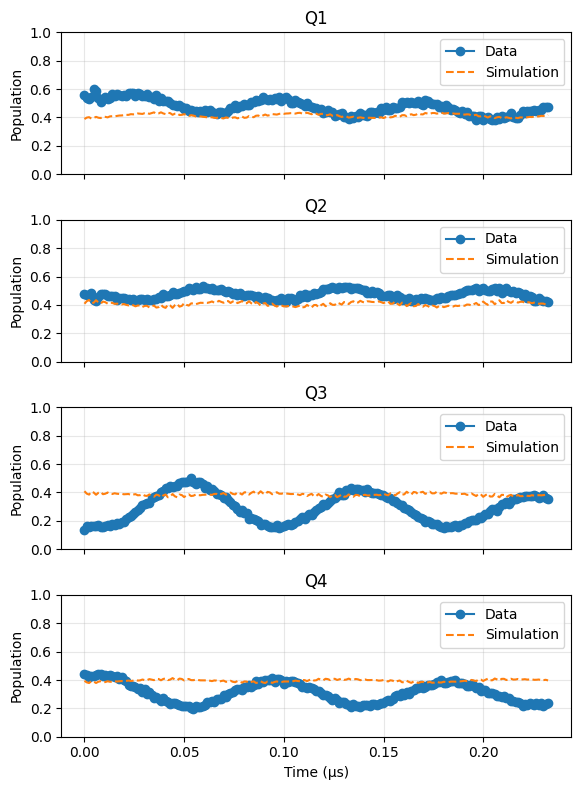

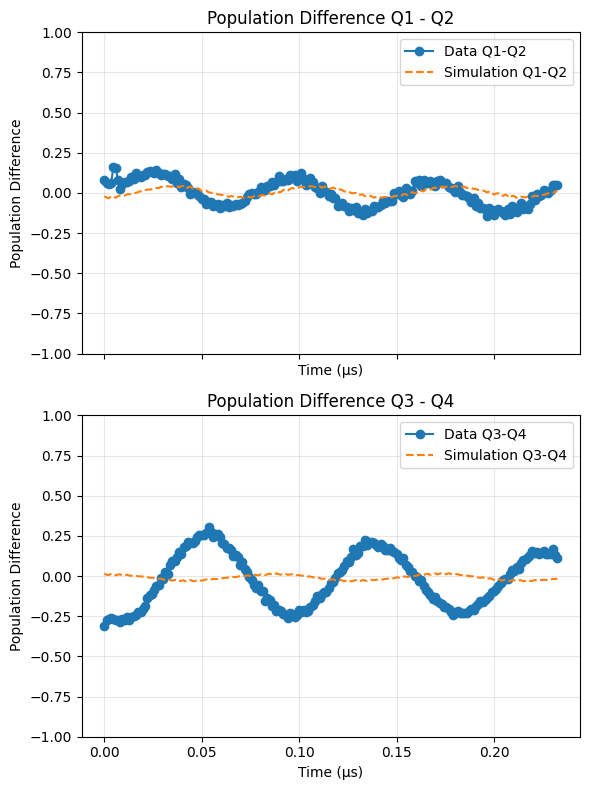

In [8]:
# Assuming populations_simulation has already been calculated and has the same shape as populations_data

# fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
fig, axes = plt.subplots(4, 1, figsize=(6, 8), sharex=True)
axes = axes.flatten()

time_step = times[1] - times[0]


# Set all axes to the same y-axis limits
ymin = min(np.min(populations_data), np.min(populations_simulation))
ymax = max(np.max(populations_data), np.max(populations_simulation))
for idx in range(4):
    axes[idx].plot(times, populations_data[idx], 'o-', label='Data')
    axes[idx].plot(times, populations_simulation[idx], '--', label='Simulation')
    axes[idx].set_title(f'Q{idx+1}')
    axes[idx].set_ylabel('Population')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend()
    axes[idx].set_ylim(0, 1)


axes[-1].set_xlabel('Time (µs)')
plt.tight_layout()
plt.show()

# Plot population differences for readout_pair_1 (Q1 - Q2) and readout_pair_2 (Q3 - Q4) using subplots

fig_diff, (axes_1, axes_2) = plt.subplots(2, 1, figsize=(6,8), sharex=True)

# Data differences
pop_diff_1_data = populations_data[readout_pair_1[0]] - populations_data[readout_pair_1[1]]
pop_diff_2_data = populations_data[readout_pair_2[0]] - populations_data[readout_pair_2[1]]

# Simulation differences
pop_diff_1_sim = populations_simulation[readout_pair_1[0]] - populations_simulation[readout_pair_1[1]]
pop_diff_2_sim = populations_simulation[readout_pair_2[0]] - populations_simulation[readout_pair_2[1]]

# Plot for readout_pair_1
axes_1.plot(times, pop_diff_1_data, 'o-', label='Data Q1-Q2')
axes_1.plot(times, pop_diff_1_sim, '--', label='Simulation Q1-Q2')
axes_1.set_title('Population Difference Q1 - Q2')
axes_1.set_xlabel('Time (µs)')
axes_1.set_ylabel('Population Difference')
axes_1.legend()
axes_1.grid(True, alpha=0.3)

axes_1.set_ylim(-1, 1)

# axes_1.axvline(abs(J_to_beamsplitter_time(J[0])/1e3), color='red', linestyle=':', label='Beamsplitter Time')

# Plot for readout_pair_2
axes_2.plot(times, pop_diff_2_data, 'o-', label='Data Q3-Q4')
axes_2.plot(times, pop_diff_2_sim, '--', label='Simulation Q3-Q4')
axes_2.set_title('Population Difference Q3 - Q4')
axes_2.set_xlabel('Time (µs)')
axes_2.set_ylabel('Population Difference')
axes_2.legend()
axes_2.grid(True, alpha=0.3)

axes_2.set_ylim(-1, 1)

# axes_2.axvline(abs(J_to_beamsplitter_time(J[-1])/1e3), color='red', linestyle=':', label='Beamsplitter Time')

# axes_2.axvline(times[10], color='black')


plt.tight_layout()
plt.show()


#### 1.2.2 Fit to Population

In [103]:

# ignore data points before start_cutoff
simulation_kwargs = dict(
    num_levels=num_levels,
    num_qubits=num_qubits,
    num_particles=num_particles,
    J=J,
    J_parallel=J_parallel,
    U=U,
    T1=T1,
    T2=T2,
    times=times,
    readout_pair_1=readout_pair_1,
    readout_pair_2=readout_pair_2,
    initial_detunings=initial_detunings,
    measurement_detuning=measurement_detuning,
    measurement_J=measurement_J,
    measurement_J_parallel=measurement_J_parallel,
    psi0=psi0,
    scale_factor=scale_factor,
)


simulation_kwargs |= modify_psi0_kwargs


print(simulation_kwargs['initial_detunings'])
print(simulation_kwargs['J'])
print(simulation_kwargs['J_parallel'])
print(simulation_kwargs['phases'])

initial_cost = cost_function(populations_data, calculate_populations_simulation(**simulation_kwargs))
print(f'initial cost: {initial_cost:.4f}')


if modify_psi0_kwargs.get('use_mixed_state', False):
    print(f'using mixed state')
if modify_psi0_kwargs.get('add_phase', False):
    print(f'adding phase before beamsplitter interaction')

fit_params = ['J', 'J_parallel', 'initial_detunings', 'phases']
# fit_params = ['initial_detunings']
# fit_params = ['phases']
fit_params = ['J', 'J_parallel', 'initial_detunings', 'phases', 'x_angles']
fit_params = ['J', 'J_parallel', 'initial_detunings', 'phases', 'x_angles', 'measurement_J']


result = fit_to_data(simulation_kwargs, populations_data, fit_params, calculate_populations_simulation)

[0.006307198045470061, -0.018669229788554665, 0.002669847929923068, 0.0367829257039464]
[-36.10540747322832, -40.11555350697211, -41.551492721901305]
[42.588219673283355, 45.32418123121505]
[0.23133882791597438, -0.2]
initial cost: 1.4173
adding phase before beamsplitter interaction
simulation_kwargs keys: dict_keys(['num_levels', 'num_qubits', 'num_particles', 'J', 'J_parallel', 'U', 'T1', 'T2', 'times', 'readout_pair_1', 'readout_pair_2', 'initial_detunings', 'measurement_detuning', 'measurement_J', 'measurement_J_parallel', 'psi0', 'scale_factor', 'add_phase', 'pairs', 'add_x_rotation', 'x_pairs', 'use_mixed_state', 'pre_ramp_detuning', 'basis_state_to_index_dict', 'mixed_basis_states', 'mixed_probabilities', 'use_mixed_ramp', 'phases', 'x_angles'])
fit params: ['J', 'J_parallel', 'initial_detunings', 'phases', 'x_angles', 'measurement_J']
<function fit_to_data.<locals>.create_objective_function.<locals>.objective_function at 0x00000205F698D360>
Key to Indices: {'J': (0, 3), 'J_para

### 1.3 Fit Covariance
Fit to the covariance of two qubit populations: $\text{Cov}(n_1,n_2) = \langle n_1 n_2 \rangle - \langle n_1 \rangle \langle n_2 \rangle$

get covariance bitstrings: [(0, 0, 0, 0, 0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 0, 1), (0, 0, 0, 0, 0, 0, 1, 0), (0, 0, 0, 0, 0, 0, 1, 1), (0, 0, 0, 0, 0, 1, 0, 0), (0, 0, 0, 0, 0, 1, 0, 1), (0, 0, 0, 0, 0, 1, 1, 0), (0, 0, 0, 0, 0, 1, 1, 1), (0, 0, 0, 0, 1, 0, 0, 0), (0, 0, 0, 0, 1, 0, 0, 1), (0, 0, 0, 0, 1, 0, 1, 0), (0, 0, 0, 0, 1, 0, 1, 1), (0, 0, 0, 0, 1, 1, 0, 0), (0, 0, 0, 0, 1, 1, 0, 1), (0, 0, 0, 0, 1, 1, 1, 0), (0, 0, 0, 0, 1, 1, 1, 1), (0, 0, 0, 1, 0, 0, 0, 0), (0, 0, 0, 1, 0, 0, 0, 1), (0, 0, 0, 1, 0, 0, 1, 0), (0, 0, 0, 1, 0, 0, 1, 1), (0, 0, 0, 1, 0, 1, 0, 0), (0, 0, 0, 1, 0, 1, 0, 1), (0, 0, 0, 1, 0, 1, 1, 0), (0, 0, 0, 1, 0, 1, 1, 1), (0, 0, 0, 1, 1, 0, 0, 0), (0, 0, 0, 1, 1, 0, 0, 1), (0, 0, 0, 1, 1, 0, 1, 0), (0, 0, 0, 1, 1, 0, 1, 1), (0, 0, 0, 1, 1, 1, 0, 0), (0, 0, 0, 1, 1, 1, 0, 1), (0, 0, 0, 1, 1, 1, 1, 0), (0, 0, 0, 1, 1, 1, 1, 1), (0, 0, 1, 0, 0, 0, 0, 0), (0, 0, 1, 0, 0, 0, 0, 1), (0, 0, 1, 0, 0, 0, 1, 0), (0, 0, 1, 0, 0, 0, 1, 1), (0, 0, 1, 0, 0, 1, 0, 0), (0, 0, 1, 

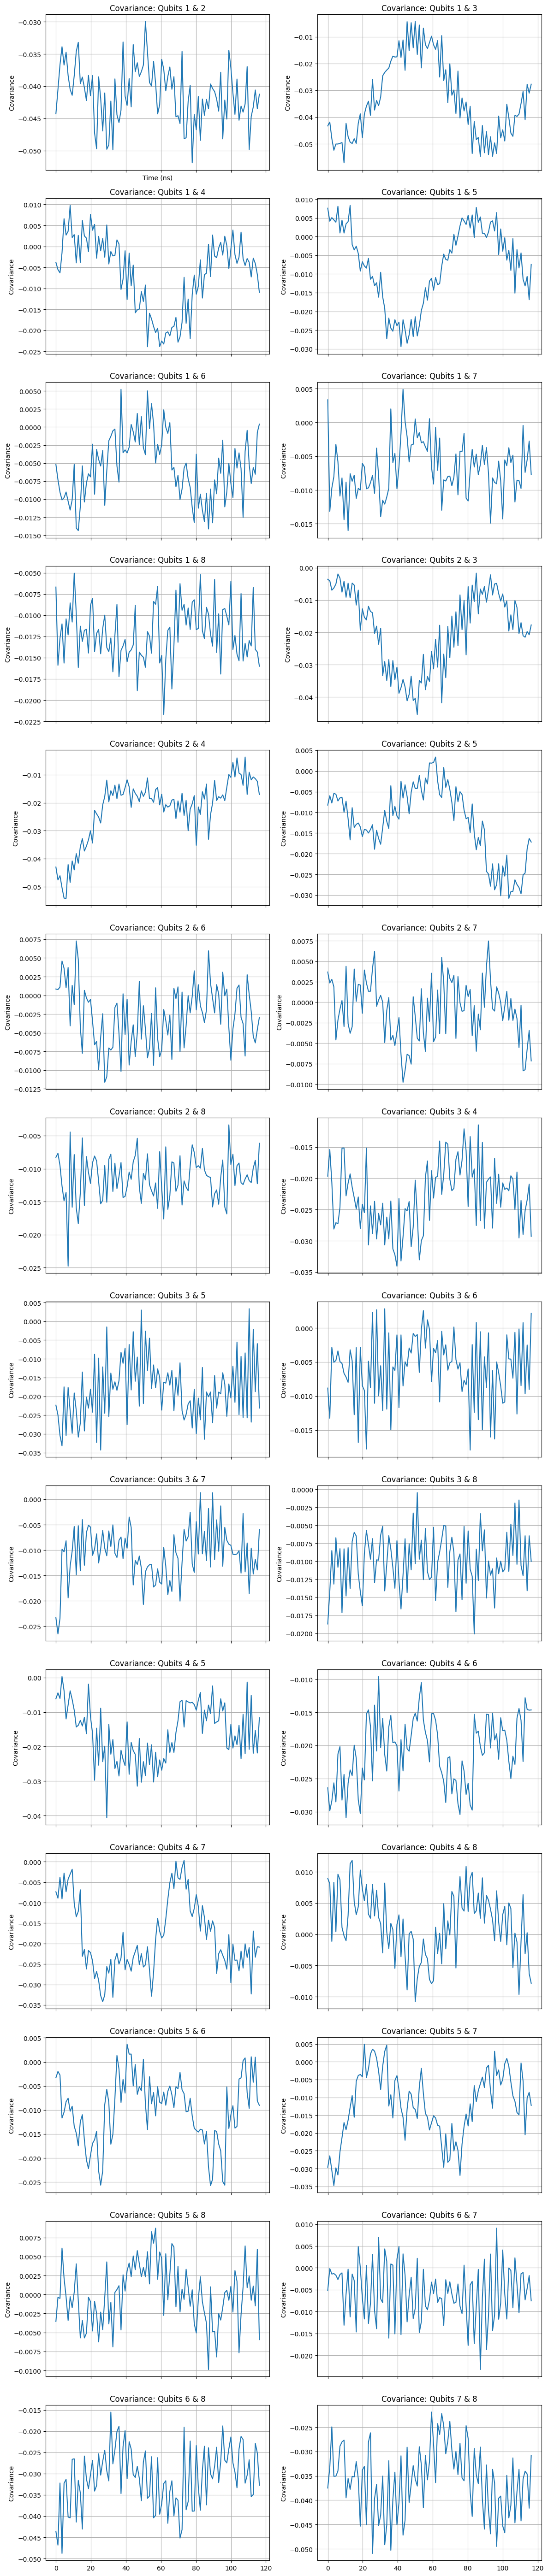

(4, 101)
Covariance Data Shape: (4, 101)


In [23]:
# state = 'HH_4Q'
state = 'HH_4Q'
state = 'HHH_6Q'
# state = 'HHH_6Q_45'
# state = 'D_0_phase1'
state = '4P8Q_1234'
state = '4P8Q_1254'

measurement = state_to_correlation_measurement[state]
initial_state_counts = measurement.get_counts()[:,0]

# order will be n12, n13, n14, n23, n24, n34

readout_pair_1 = [0, 1]  
readout_pair_2 = [2, 3]

covariance_data = []

covariance_data_matrix = measurement.get_covariance()
# covariance_data_matrix = measurement.get_covariance_corrected()

# print(covariance_data_matrix[0,1])

covariance_data = np.zeros((4, covariance_data_matrix.shape[-1]), dtype=np.float64)

# measurement.plot_covariance(both=True)
measurement.plot_covariance()
index = 0


for i in range(4):
    for j in range(i+1, 4):
        if (i == 0 and j == 1) or (i == 2 and j == 3):
                continue
        covariance_data[index,:] = covariance_data_matrix[i, j, :]
        # print(covariance_data_matrix[i, j, :])
        # print(covariance_dta[index,:])
        index += 1

covariance_data = np.array(covariance_data)
print(covariance_data.shape)

current_correlation_data = covariance_data[0,:] - covariance_data[1,:] - covariance_data[2,:] + covariance_data[3,:]
print("Covariance Data Shape:", covariance_data.shape)

#### 1.3.1 Parameters and Initial Guess

In [24]:
### 4 qubits

importlib.reload(src.src_current_measurement_fits)
from src.src_current_measurement_fits import calculate_covariance_simulation

num_levels = 3
num_qubits = 4

# 0 flux
J = -np.array([5.75, 6.39, 6.61]) * 2 * np.pi # MHz
J_parallel = -np.array([6.78, 7.21]) * 2 * np.pi # MHz

# pi flux
# J = -np.array([6.26, 5.9, 5.95]) * 2 * np.pi # MHz
# J_parallel = -np.array([7.25, 7.65]) * 2 * np.pi # MHz


initial_detunings = np.array([0, 0, 0, 0]) * 2 * np.pi # MHz
psi0_angles = [np.pi, 0, np.pi, 0]  # theta_1, phi_1, theta_2, phi_2
scale_factor = 1.0



measurement_J = -np.array([6.96, 5.9, 5.88]) * 2 * np.pi # MHz
measurement_J_parallel = J_parallel.copy()
measurement_detuning = np.array([300, 300, -300, -300]) * 2 * np.pi  # MHz


U = -180 * 2 * np.pi

T1 = 200  # 40 microseconds
T2 = 10  # 5 microseconds

T1 = None
T2 = None


# use the times from the measurement and convert to microseconds
times = measurement.get_times() * 1e-3  # Time in microseconds

readout_pair_1 = [0, 1]
readout_pair_2 = [2, 3]


### modify initial state

modify_psi0_kwargs = {}

modify_psi0_kwargs['add_phase'] = False
modify_psi0_kwargs['pairs'] = [readout_pair_1, readout_pair_2]
modify_psi0_kwargs['phases'] = [np.pi/4, np.pi/8]
modify_psi0_kwargs['phases'] = [0, 0]

modify_psi0_kwargs['add_x_rotation'] = False
modify_psi0_kwargs['x_pairs'] = [readout_pair_1, readout_pair_2]
modify_psi0_kwargs['x_angles'] = [0, 0]


if state == 'CD_0_phase1':
    psi0 = -1
    num_particles = 2
    psi0_bitstring = '1001'

    modify_psi0_kwargs['add_phase'] = True
    modify_psi0_kwargs['phases'] = [0.6446500386687627, 0.3685980233648204]

    J = [-36.12831423513368, -40.14955344916671, -41.531853134842116]
    J_parallel = [42.59999742056873, 45.30176848276966]
    initial_detunings = [-8.564830655084528e-07, -7.851787455585877e-07, 1.5878268090849968e-06, 1.2445277729930022e-06]
    phases = [0.1999997648167731, -0.09999985716122003]
    phases = [0.1999997648167731, -0.09999985716122003]

    modify_psi0_kwargs['phases'] = [0, 0]


    measurement_J = -np.array([6.96, 5.9, 6.5]) * 2 * np.pi # MHz

    scale_factor = 1

    modify_psi0_kwargs['add_x_rotation'] = True
    x_angles = [3*np.pi/4, 3*np.pi/4]
    x_angles = [-np.pi/4, -np.pi/4]

    # without phase suppression
    J = [-36.10578025741489, -40.115459753793374, -41.551226601701636]
    J_parallel = [42.58836841278678, 45.32400457908101]
    initial_detunings = [0.008282350141784498, -0.018142103269883546, 0.0014769944815681733, 0.03555081053551961]
    phases = [0.2522289596836303, -0.2981070283065213]
    # phases = [0, 0]
    x_angles = [0.015094402968233571, -0.009952880035159546]
    measurement_J = [-43.732643474294704, -37.070691004684875, -37.70794168867912]

    # J = [-36.12831423513368, -40.14955344916671, -41.531853134842116]
    # J_parallel = [42.59999742056873, 45.30176848276966]
    # measurement_J = [-43.73096973796992, -37.07079331235956, -40.840704496667314]
    # measurement_J_parallel = [42.599996382677595, 45.30176606476482]
    # initial_detunings = [-8.564830655084528e-07, -7.851787455585877e-07, 1.5878268090849968e-06, 1.2445277729930022e-06]
    # phases = [np.pi/2, np.pi/2]
    # x_angles = [-0.7853981633974483, -0.7853981633974483]

    modify_psi0_kwargs['use_mixed_state'] = False
    print(modify_psi0_kwargs['use_mixed_state'])

    modify_psi0_kwargs['pre_ramp_detuning'] = np.array([100, -100, -105, 0])
    modify_psi0_kwargs['basis_state_to_index_dict'] = create_basis_state_to_index_mapping(num_levels, num_qubits, modify_psi0_kwargs['pre_ramp_detuning'], U)


    modify_psi0_kwargs['mixed_basis_states'] = ['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
    modify_psi0_kwargs['mixed_probabilities'] = [0.014, 0.0794, 0.0038, 0.0104, 0.0092, 0.0144, 0.001, 0.0002, 0.0994, 0.705, 0.0154, 0.031, 0.0082, 0.0076, 0.0006, 0.0004]

    modify_psi0_kwargs['use_mixed_ramp'] = False
    modify_psi0_kwargs['mixed_probabilities'] = initial_state_counts / np.sum(initial_state_counts)
elif state == 'CD_0_phase2':
    psi0 = -1
    num_particles = 2
    psi0_bitstring = '1001'

    modify_psi0_kwargs['add_phase'] = True
    initial_detunings = [1.6487278690604081, -21.84594354013756, -18.53794600081936, -6.2282654509220325]
    modify_psi0_kwargs['phases'] = [3.1415925586617526, 3.141592653589793]
    modify_psi0_kwargs['phases'] = [1.0976722685652056, 0.46360232859603423]

    scale_factor = 1

    modify_psi0_kwargs['use_mixed_state'] = False
    print(modify_psi0_kwargs['use_mixed_state'])

    modify_psi0_kwargs['pre_ramp_detuning'] = np.array([100, -100, -105, 0])
    modify_psi0_kwargs['basis_state_to_index_dict'] = create_basis_state_to_index_mapping(num_levels, num_qubits, modify_psi0_kwargs['pre_ramp_detuning'], U)


    modify_psi0_kwargs['mixed_basis_states'] = ['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
    modify_psi0_kwargs['mixed_probabilities'] = [0.014, 0.0794, 0.0038, 0.0104, 0.0092, 0.0144, 0.001, 0.0002, 0.0994, 0.705, 0.0154, 0.031, 0.0082, 0.0076, 0.0006, 0.0004]
     
elif state == 'BD':
    psi0 = -2
    num_particles = 2
    psi0_bitstring = '1100'
elif state == 'BC':
    psi0 = -3
    num_particles = 2
    psi0_bitstring = '0101'
elif state == 'D':
    psi0 = -1
    num_particles = 1
    psi0_bitstring = '0001'
elif state == 'A':
    psi0 = 0
    num_particles = 1
    psi0_bitstring = '1000'
elif state == 'B':
    psi0 = 1
    num_particles = 1
    psi0_bitstring = '0100'

elif state == 'HH_4Q':
    psi0 = -1
    num_particles = 2
    psi0_bitstring = '1001'

    modify_psi0_kwargs['add_phase'] = True
    modify_psi0_kwargs['phases'] = [0.6446500386687627, 0.3685980233648204]


    measurement_J = -np.array([6.96, 5.9, 6.5]) * 2 * np.pi # MHz

    scale_factor = 1

    modify_psi0_kwargs['add_x_rotation'] = True
    x_angles = [3*np.pi/4, 3*np.pi/4]
    x_angles = [-np.pi/4, -np.pi/4]

    J = [-36.105779614619294, -40.115458915415886, -41.551226199974806]
    J_parallel = [-42.5883694036731, -45.324005115037366]
    measurement_J = [-43.73264346827821, -37.07069100481735, -37.70794168268571]
    measurement_J_parallel = [-8.517673880734584, -9.06480102299777]
    initial_detunings = [0.008283174717813228, -0.018140627992680486, 0.0014779886606578173, 0.03555194522271596]
    phases = [0.2522289673368646, -0.29810703692463314]
    x_angles = [-1.57079632679633, -0.009952908076292113]

   

    modify_psi0_kwargs['use_mixed_state'] = False
    print(modify_psi0_kwargs['use_mixed_state'])

    modify_psi0_kwargs['pre_ramp_detuning'] = np.array([100, -100, -105, 0])
    modify_psi0_kwargs['basis_state_to_index_dict'] = create_basis_state_to_index_mapping(num_levels, num_qubits, modify_psi0_kwargs['pre_ramp_detuning'], U)


    modify_psi0_kwargs['mixed_basis_states'] = ['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
    modify_psi0_kwargs['mixed_probabilities'] = [0.014, 0.0794, 0.0038, 0.0104, 0.0092, 0.0144, 0.001, 0.0002, 0.0994, 0.705, 0.0154, 0.031, 0.0082, 0.0076, 0.0006, 0.0004]

    modify_psi0_kwargs['use_mixed_ramp'] = False
    modify_psi0_kwargs['mixed_probabilities'] = initial_state_counts / np.sum(initial_state_counts)
 
    

# if True, use uncoupled Hamiltonian for beamsplitter simulation
# uncoupled = True
uncoupled = False


modify_psi0_kwargs['phases'] = phases
modify_psi0_kwargs['x_angles'] = x_angles


covariance_simulation, current_measurement_simulation = calculate_covariance_simulation(num_levels, num_qubits, num_particles, J, J_parallel, U, times, readout_pair_1, 
                                                  readout_pair_2, initial_detunings, measurement_detuning, psi0=psi0,
                                                  measurement_J=measurement_J, measurement_J_parallel=measurement_J_parallel,
                                                  scale_factor=scale_factor, T1=T1, T2=T2, print_logs=True, uncoupled=uncoupled, return_simulation_object=True,
                                                  **modify_psi0_kwargs)



print(f'cost: {cost_function(covariance_data, covariance_simulation):.4f}')

current_correlation_simulation = covariance_simulation[0,:] - covariance_simulation[1,:] - covariance_simulation[2,:] + covariance_simulation[3,:]

current_correlation_simulation_from_operator = current_measurement_simulation.get_current_correlation_from_operator()

psi0 dims: [[3, 3, 3, 3], [1, 1, 1, 1]]
psi0 is a state vector
initial state before modifying is state vector
initial state after modifying is state vector
running simulation
running sesolve
cost: 0.1918


In [13]:
### 5 qubits

importlib.reload(src.src_current_measurement_fits)
from src.src_current_measurement_fits import calculate_covariance_simulation

num_levels = 3
num_qubits = 5

# pi flux
J = -np.array([6.02, 6.26, 6.01, 6.23, 6.07, 6.36, 6.13])[:4] * 2 * np.pi # MHz
J_parallel = -np.array([7.08, 7.33, 7.30, 7.70, 7.26, 7.01])[:3] * 2 * np.pi # MHz


initial_detunings = np.array([0, 0, 0, 0, 0]) * 2 * np.pi # MHz



measurement_J = J.copy()
measurement_J_parallel = J_parallel.copy()
measurement_detuning = np.array([550, 550, -100, -100, 200, 200, 200, 200])[:5] * 2 * np.pi  # MHz


U = -180 * 2 * np.pi

T1 = 200  # 40 microseconds
T2 = 10  # 5 microseconds

T1 = None
T2 = None


# use the times from the measurement and convert to microseconds
times = measurement.get_times() * 1e-3  # Time in microseconds

readout_pair_1 = [0, 1]
readout_pair_2 = [2, 3]


### modify initial state

modify_psi0_kwargs = {}

modify_psi0_kwargs['add_phase'] = False
modify_psi0_kwargs['pairs'] = [readout_pair_1, readout_pair_2]
modify_psi0_kwargs['phases'] = [np.pi/4, np.pi/8]

modify_psi0_kwargs['add_x_rotation'] = False
modify_psi0_kwargs['x_pairs'] = [readout_pair_1, readout_pair_2]
modify_psi0_kwargs['x_angles'] = [0]


if state == 'HH_5Q':
    psi0 = -1
    num_particles = 2
    psi0_bitstring = '1001'

    modify_psi0_kwargs['add_phase'] = True
    modify_psi0_kwargs['phases'] = [0, 0]

  
    phase = [0, 0]

    scale_factor = 1

    modify_psi0_kwargs['add_x_rotation'] = True

    x_angles = [0, np.pi/4]


    modify_psi0_kwargs['use_mixed_state'] = False
    print(modify_psi0_kwargs['use_mixed_state'])

    modify_psi0_kwargs['pre_ramp_detuning'] = np.array([100, -100, -105, 0, -150])
    modify_psi0_kwargs['basis_state_to_index_dict'] = create_basis_state_to_index_mapping(num_levels, num_qubits, modify_psi0_kwargs['pre_ramp_detuning'], U)


    modify_psi0_kwargs['mixed_basis_states'] = ['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
    modify_psi0_kwargs['mixed_probabilities'] = [0.014, 0.0794, 0.0038, 0.0104, 0.0092, 0.0144, 0.001, 0.0002, 0.0994, 0.705, 0.0154, 0.031, 0.0082, 0.0076, 0.0006, 0.0004]

    modify_psi0_kwargs['use_mixed_ramp'] = False
    modify_psi0_kwargs['mixed_probabilities'] = initial_state_counts / np.sum(initial_state_counts)


# if True, use uncoupled Hamiltonian for beamsplitter simulation
# uncoupled = True
uncoupled = False


modify_psi0_kwargs['phases'] = phases
modify_psi0_kwargs['x_angles'] = x_angles


covariance_simulation, current_measurement_simulation = calculate_covariance_simulation(num_levels, num_qubits, num_particles, J, J_parallel, U, times, readout_pair_1, 
                                                  readout_pair_2, initial_detunings, measurement_detuning, psi0=psi0,
                                                  measurement_J=measurement_J, measurement_J_parallel=measurement_J_parallel,
                                                  scale_factor=scale_factor, T1=T1, T2=T2, print_logs=True, uncoupled=uncoupled, return_simulation_object=True,
                                                  **modify_psi0_kwargs)



print(f'cost: {cost_function(covariance_data, covariance_simulation):.4f}')

current_correlation_simulation = covariance_simulation[0,:] - covariance_simulation[1,:] - covariance_simulation[2,:] + covariance_simulation[3,:]

current_correlation_simulation_from_operator = current_measurement_simulation.get_current_correlation_from_operator()

psi0 dims: [[3, 3, 3, 3, 3], [1, 1, 1, 1, 1]]
psi0 is a state vector
initial state before modifying is state vector
initial state after modifying is state vector
running simulation
running sesolve
cost: 4.2406


In [273]:
### 6 qubits

importlib.reload(src.src_current_measurement_fits)
from src.src_current_measurement_fits import calculate_populations_simulation

num_levels = 3
num_qubits = 6

# pi flux
J = -np.array([6.02, 6.26, 6.01, 6.23, 6.07, 6.36, 6.13])[:num_qubits-1] * 2 * np.pi # MHz
J_parallel = -np.array([7.08, 7.33, 7.30, 7.70, 7.26, 7.01])[:num_qubits-2] * 2 * np.pi # MHz


initial_detunings = np.array([0, 0, 0, 0, 0, 0]) * 2 * np.pi # MHz



measurement_J = J.copy()
measurement_J_parallel = J_parallel.copy()
measurement_detuning = np.array([550, 550, -100, -100, 200, 200, 200, 200])[:num_qubits] * 2 * np.pi  # MHz


U = -180 * 2 * np.pi

T1 = 200  # 40 microseconds
T2 = 10  # 5 microseconds

T1 = None
T2 = None


# use the times from the measurement and convert to microseconds
times = measurement.get_times() * 1e-3  # Time in microseconds

readout_pair_1 = [0, 1]
readout_pair_2 = [2, 3]


### modify initial state

modify_psi0_kwargs = {}

modify_psi0_kwargs['add_phase'] = False
modify_psi0_kwargs['pairs'] = [readout_pair_1, readout_pair_2]
modify_psi0_kwargs['phases'] = [0, 0]

modify_psi0_kwargs['add_x_rotation'] = False
modify_psi0_kwargs['x_pairs'] = [readout_pair_1, readout_pair_2]
modify_psi0_kwargs['x_angles'] = [0, 0]


if state == 'HHH_6Q':
    psi0 = -1
    num_particles = 3
    psi0_bitstring = '100110'

    modify_psi0_kwargs['add_phase'] = True
    phases = [0, 0]

    initial_detunings = [0]*num_qubits

    initial_detunings = np.array([2, 0, 0, 0, 0, 0]) * 2 * np.pi # MHz


    scale_factor = 1

    modify_psi0_kwargs['add_x_rotation'] = True
    x_angles = [0, 0]


    modify_psi0_kwargs['use_mixed_state'] = False
    print(modify_psi0_kwargs['use_mixed_state'])

    modify_psi0_kwargs['pre_ramp_detuning'] = np.array([50, -200, -200, 100, -100, -200])*2*np.pi
    modify_psi0_kwargs['basis_state_to_index_dict'] = create_basis_state_to_index_mapping(num_levels, num_qubits, modify_psi0_kwargs['pre_ramp_detuning'], U)


    modify_psi0_kwargs['mixed_basis_states'] = ['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
    modify_psi0_kwargs['mixed_probabilities'] = [0.014, 0.0794, 0.0038, 0.0104, 0.0092, 0.0144, 0.001, 0.0002, 0.0994, 0.705, 0.0154, 0.031, 0.0082, 0.0076, 0.0006, 0.0004]

    modify_psi0_kwargs['use_mixed_ramp'] = False
    modify_psi0_kwargs['mixed_probabilities'] = initial_state_counts / np.sum(initial_state_counts)


# if True, use uncoupled Hamiltonian for beamsplitter simulation
# uncoupled = True
uncoupled = False


modify_psi0_kwargs['phases'] = phases
modify_psi0_kwargs['x_angles'] = x_angles


covariance_simulation, current_measurement_simulation = calculate_covariance_simulation(num_levels, num_qubits, num_particles, J, J_parallel, U, times, readout_pair_1, 
                                                  readout_pair_2, initial_detunings, measurement_detuning, psi0=psi0,
                                                  measurement_J=measurement_J, measurement_J_parallel=measurement_J_parallel,
                                                  scale_factor=scale_factor, T1=T1, T2=T2, print_logs=True, uncoupled=uncoupled, return_simulation_object=True,
                                                  **modify_psi0_kwargs)



print(f'cost: {cost_function(covariance_data, covariance_simulation):.4f}')

current_correlation_simulation = covariance_simulation[0,:] - covariance_simulation[1,:] - covariance_simulation[2,:] + covariance_simulation[3,:]

current_correlation_simulation_from_operator = current_measurement_simulation.get_current_correlation_from_operator()

False
psi0 dims: [[3, 3, 3, 3, 3, 3], [1, 1, 1, 1, 1, 1]]
psi0 is a state vector
initial state before modifying is state vector
adding phase ([0.0, 0.0] pi) to pairs ([[0, 1], [2, 3]])
adding x rotation ([0.0, 0.0] pi) to pairs ([[0, 1], [2, 3]])
initial state after modifying is state vector
running simulation
running sesolve
cost: 1.5657


In [17]:
### 8 qubits

importlib.reload(src.src_current_measurement_fits)
from src.src_current_measurement_fits import calculate_populations_simulation

num_levels = 4
num_qubits = 8

# pi flux
J = -np.array([6.02, 6.26, 6.01, 6.23, 6.07, 6.36, 6.13]) * 2 * np.pi # MHz
J_parallel = -np.array([7.08, 7.33, 7.30, 7.70, 7.26, 7.01]) * 2 * np.pi # MHz


initial_detunings = np.array([0, 0, 0, 0, 0, 0, 0, 0]) * 2 * np.pi # MHz
scale_factor = 1.0



measurement_J = J.copy()
measurement_J_parallel = J_parallel.copy()

measurement_detuning = np.array([-200, -200, 600, 600, -100, -100, 400, 400]) * 2 * np.pi  # MHz
measurement_detuning = np.array([-200, -200, 200, 600, 600, -100, -100, 500]) * 2 * np.pi  # MHz
# measurement_detuning = np.array([300, 300, -300, -302]) * 2 * np.pi  # MHz


U = -180 * 2 * np.pi

T1 = 50  # 40 microseconds
T2 = 2  # 5 microseconds

T1 = None
T2 = None

# use the times from the measurement and convert to microseconds
# times = measurement.get_times() * 1e-3  # Time in microseconds

readout_pair_1 = [0, 1]
readout_pair_2 = [2, 3]


### modify initial state

modify_psi0_kwargs = {}

modify_psi0_kwargs['add_phase'] = True
modify_psi0_kwargs['pairs'] = [readout_pair_1, readout_pair_2]
phases = [0.0, 0.0]

modify_psi0_kwargs['add_x_rotation'] = True
modify_psi0_kwargs['x_pairs'] = [readout_pair_1, readout_pair_2]
x_angles = [0.0, 0.0]

if state == 'HHHH_phase_1':
    psi0 = -1
    num_particles = 2
    psi0_bitstring = '01010'



    modify_psi0_kwargs['use_mixed_state'] = False

    
    modify_psi0_kwargs['use_mixed_ramp'] = False
    modify_psi0_kwargs['mixed_probabilities'] = initial_state_counts / np.sum(initial_state_counts)


elif state == '4P8Q_1234' or state == '4P8Q_1254':
    psi0 = -1
    num_particles = 4
    psi0_bitstring = '10011001'

# if True, use uncoupled Hamiltonian for beamsplitter simulation
# uncoupled = True
uncoupled = False

modify_psi0_kwargs['use_mixed_state'] = False
modify_psi0_kwargs['use_mixed_ramp'] = False

modify_psi0_kwargs['phases'] = phases

modify_psi0_kwargs['x_angles'] = x_angles

num_particles = 4
psi0 = -1
print(modify_psi0_kwargs['phases'])
print(modify_psi0_kwargs['x_pairs'])

covariance_simulation, current_measurement_simulation = calculate_covariance_simulation(num_levels, num_qubits, num_particles, J, J_parallel, U, times, readout_pair_1, 
                                                  readout_pair_2, initial_detunings, measurement_detuning, psi0=psi0,
                                                  measurement_J=measurement_J, measurement_J_parallel=measurement_J_parallel,
                                                  scale_factor=scale_factor, T1=T1, T2=T2, print_logs=True, uncoupled=uncoupled, **modify_psi0_kwargs,
                                                  return_simulation_object=True)


current_correlation_simulation = covariance_simulation[0,:] - covariance_simulation[1,:] - covariance_simulation[2,:] + covariance_simulation[3,:]

print(f'cost: {cost_function(covariance_data, covariance_simulation):.4f}')



[0.0, 0.0]
[[0, 1], [2, 3]]
__init__
processing psi0, given type: <class 'int'>


MemoryError: Unable to allocate 64.0 GiB for an array with shape (65536, 65536) and data type complex128

In [18]:
# print(list(current_measurement_simulation.psi0.full()[:,0]))

print(current_measurement_simulation.psi0)

Quantum object: dims=[[3, 3, 3, 3, 3, 3, 3, 3], [1, 1, 1, 1, 1, 1, 1, 1]], shape=(6561, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.00000000e+00]
 [-4.77075971e-26]
 [ 5.99091288e-17]
 ...
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]


In [26]:
# current_correlation_simulation_1234 = current_correlation_simulation
# current_correlation_simulation_1254 = current_correlation_simulation
# current_correlation_simulation = current_correlation_simulation_1254

In [31]:
readout_pair_1 = [0, 1]
readout_pair_2 = [6, 5]

covariance_matrix = current_measurement_simulation.get_covariance()

current_correlation_simulation = covariance_matrix[readout_pair_1[0], readout_pair_2[0],:] - covariance_matrix[readout_pair_1[0], readout_pair_2[1],:] - covariance_matrix[readout_pair_1[1], readout_pair_2[0],:] + covariance_matrix[readout_pair_1[1], readout_pair_2[1],:]
print(np.max(current_correlation_simulation))


0.007029448724178378


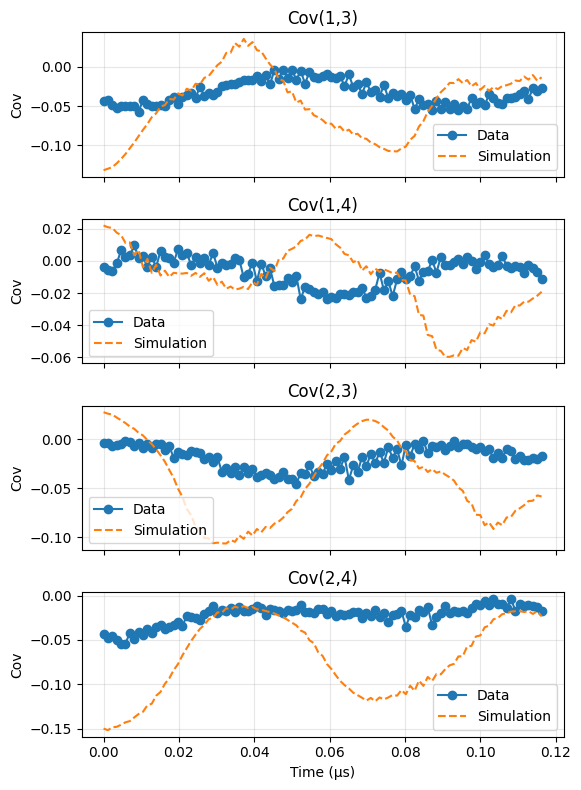

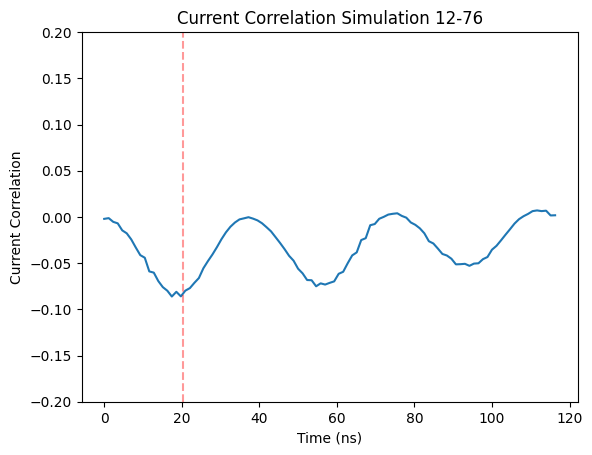

In [32]:
# Assuming n_terms_simulation has already been calculated and has the same shape as n_terms_data
beamsplitter_time = abs((np.pi/4 + modify_psi0_kwargs['x_angles'][0])/(measurement_J[0]))*1e3
beamsplitter_time = abs((np.pi/4 + np.pi/4)/(measurement_J[0]))*1e3

# fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
fig, axes = plt.subplots(4, 1, figsize=(6, 8), sharex=True)
axes = axes.flatten()

labels = ['Cov(1,3)', 'Cov(1,4)', 'Cov(2,3)', 'Cov(2,4)']

for idx in range(4):
    axes[idx].plot(times, covariance_data[idx], 'o-', label='Data')
    axes[idx].plot(times, covariance_simulation[idx], '--', label='Simulation')
    axes[idx].set_title(labels[idx])
    axes[idx].set_ylabel('Cov')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend()

axes[-1].set_xlabel('Time (µs)')
plt.tight_layout()
plt.show()

# plt.plot(times, current_correlation_data, 'o-', label='Measured Correlation')
# plt.plot(times, current_correlation_simulation, '--', label='Simulated Correlation')
plt.plot(times*1e3, current_correlation_simulation, label='Simulated Correlation')
# plt.plot(times, current_correlation_simulation_from_operator/(J[0]*J[-1]), ':', label='Simulated Correlation from Operator')
# plt.axvline(beamsplitter_time/1e3, color='r', alpha=0.4, linestyle='--', label='Beamsplitter Time')
# plt.xlabel('Time (µs)')
plt.xlabel('Time (ns)')
plt.ylabel('Current Correlation')
plt.title('Current Correlation Simulation 12-76')
plt.ylim(-0.2, 0.2)

beamsplitter_time = 20.4
plt.axvline(beamsplitter_time, color='r', alpha=0.4, linestyle='--', label='Beamsplitter Time')

# plt.legend()
plt.show()

In [33]:
beamsplitter_index = np.argmin(np.abs(times*1e3 - beamsplitter_time))
print("Beamsplitter Index:", beamsplitter_index)
print("Current Correlation Simulation:", current_correlation_simulation[beamsplitter_index])

Beamsplitter Index: 18
Current Correlation Simulation: -0.07976796145084522


In [ ]:
current_correlation_simulation

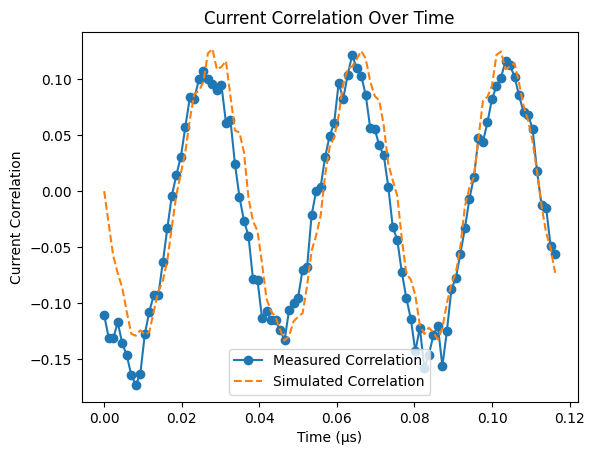

In [23]:

# ignore data points before start_cutoff
start_cutoff = 0

simulation_kwargs = dict(
    num_levels=num_levels,
    num_qubits=num_qubits,
    num_particles=num_particles,
    J=J,
    J_parallel=J_parallel,
    U=U,
    T1=T1,
    T2=T2,
    times=times,
    readout_pair_1=readout_pair_1,
    readout_pair_2=readout_pair_2,
    initial_detunings=initial_detunings,
    measurement_detuning=measurement_detuning,
    measurement_J=measurement_J,
    measurement_J_parallel=measurement_J_parallel,
    psi0=psi0,
    scale_factor=scale_factor,
    start_cutoff=start_cutoff,
)


simulation_kwargs |= modify_psi0_kwargs


print(simulation_kwargs['initial_detunings'])
print(simulation_kwargs['J'])
print(simulation_kwargs['J_parallel'])
print(simulation_kwargs['phases'])

initial_cost = cost_function(covariance_data, calculate_covariance_simulation(**simulation_kwargs))
print(f'initial cost: {initial_cost:.4f}')


if modify_psi0_kwargs.get('use_mixed_state', False):
    print(f'using mixed state')
if modify_psi0_kwargs.get('add_phase', False):
    print(f'adding phase before beamsplitter interaction')

fit_params = ['J', 'J_parallel', 'measurement_J', 'measurement_J_parallel', 'initial_detunings', 'phases', 'x_angles']
# fit_params = ['initial_detunings', 'phases']
# fit_params = ['phases']


result = fit_to_data(simulation_kwargs, covariance_data, fit_params, calculate_covariance_simulation)

[0.008283174672705076, -0.01814062792544097, 0.0014779887279235762, 0.03555194529002735]
[-36.10577961458064, -40.11545891537294, -41.55122619997463]
[-42.58836940367293, -45.32400511498884]
[0.2522289673357808, -0.29810703692374985]
initial cost: 2.5837
adding phase before beamsplitter interaction
simulation_kwargs keys: dict_keys(['num_levels', 'num_qubits', 'num_particles', 'J', 'J_parallel', 'U', 'T1', 'T2', 'times', 'readout_pair_1', 'readout_pair_2', 'initial_detunings', 'measurement_detuning', 'measurement_J', 'measurement_J_parallel', 'psi0', 'scale_factor', 'start_cutoff', 'add_phase', 'pairs', 'phases', 'add_x_rotation', 'x_pairs', 'x_angles', 'use_mixed_state', 'pre_ramp_detuning', 'basis_state_to_index_dict', 'mixed_basis_states', 'mixed_probabilities', 'use_mixed_ramp'])
fit params: ['J', 'J_parallel', 'measurement_J', 'measurement_J_parallel', 'initial_detunings', 'phases', 'x_angles']
<function fit_to_data.<locals>.create_objective_function.<locals>.objective_function at

In [87]:
### check population swaps with a manual offset on one pair of qubits

plot_data = True
# plot_data = False


readout_pair_1 = [0, 1]
readout_pair_2 = [2, 3]
readout_pairs = [readout_pair_1, readout_pair_2]

state = '3P6Q_1234'
state = '3P6Q_1245'

measurement = state_to_correlation_measurement[state]


population = measurement.get_population_corrected()
times = measurement.get_times()



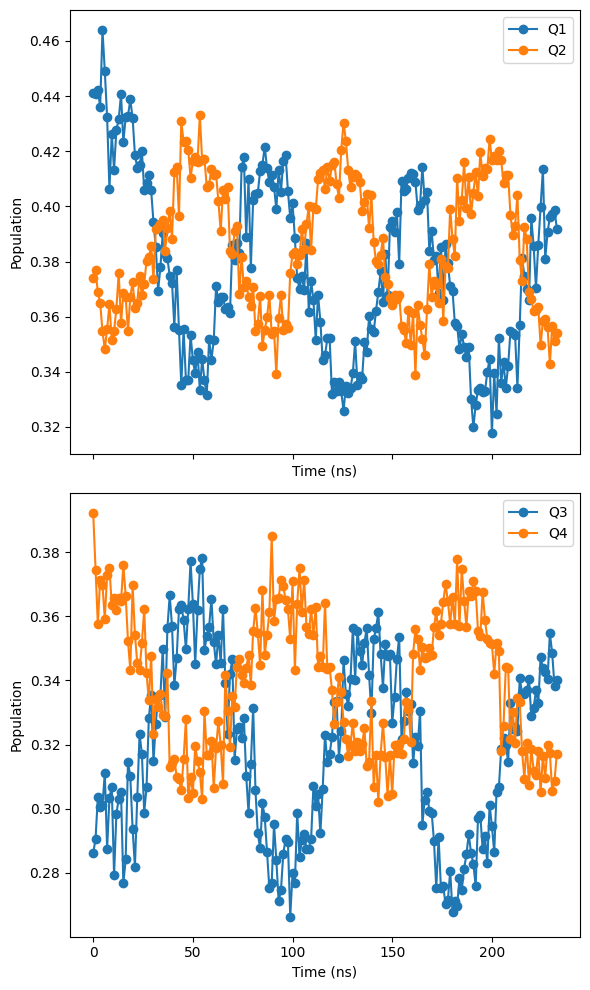

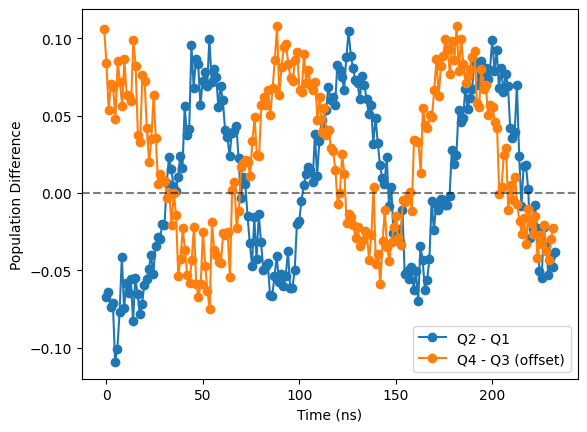

In [86]:
fig, axs = plt.subplots(2, 1, figsize=(6, 10), sharex=True)
axs = axs.flatten()

axs[0].plot(times, population[0], 'o-', label='Q1')
axs[0].plot(times, population[1], 'o-', label='Q2')
axs[0].set_xlabel('Time (ns)')
axs[0].set_ylabel('Population')
axs[0].legend()


# offset Q3-Q4 data by some amount
time_offset = -1

axs[1].plot(times, population[2], 'o-', label='Q3')
axs[1].plot(times, population[3], 'o-', label='Q4')

axs[1].set_xlabel('Time (ns)')
axs[1].set_ylabel('Population')
axs[1].legend()

plt.tight_layout()

plt.show()

population_differences = np.array([population[1] - population[0],
                                    population[3] - population[2]])

plt.plot(times, population_differences[0], 'o-', label='Q2 - Q1')
plt.plot(times + time_offset, population_differences[1], 'o-', label='Q4 - Q3 (offset)')
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.xlabel('Time (ns)')
plt.ylabel('Population Difference')
plt.legend()

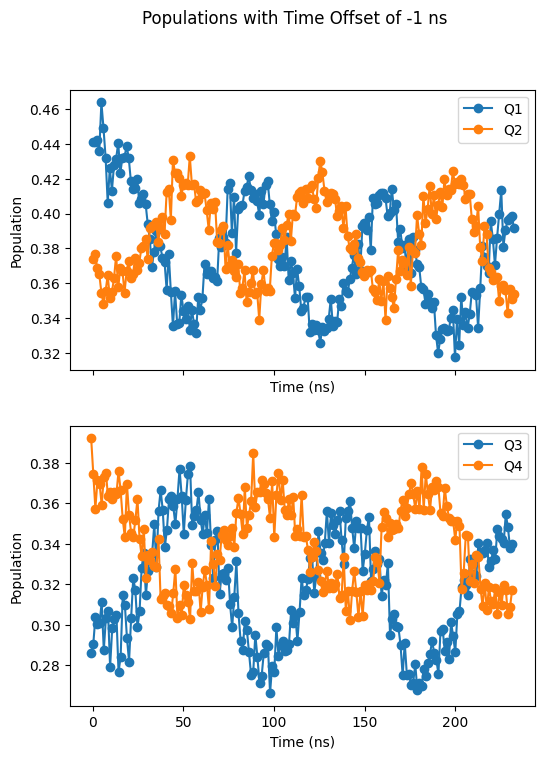

In [89]:
fig, axs = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
axs = axs.flatten()

axs[0].plot(times, population[0], 'o-', label='Q1')
axs[0].plot(times, population[1], 'o-', label='Q2')
axs[0].set_xlabel('Time (ns)')
axs[0].set_ylabel('Population')
axs[0].legend()


# offset Q3-Q4 data by some amount
time_offset = -1

axs[1].plot(times + time_offset, population[2], 'o-', label='Q3')
axs[1].plot(times + time_offset, population[3], 'o-', label='Q4')

axs[1].set_xlabel('Time (ns)')
axs[1].set_ylabel('Population')
axs[1].legend()

plt.suptitle(f'Populations with Time Offset of {time_offset} ns')
plt.show()

(4, 201, 5000)


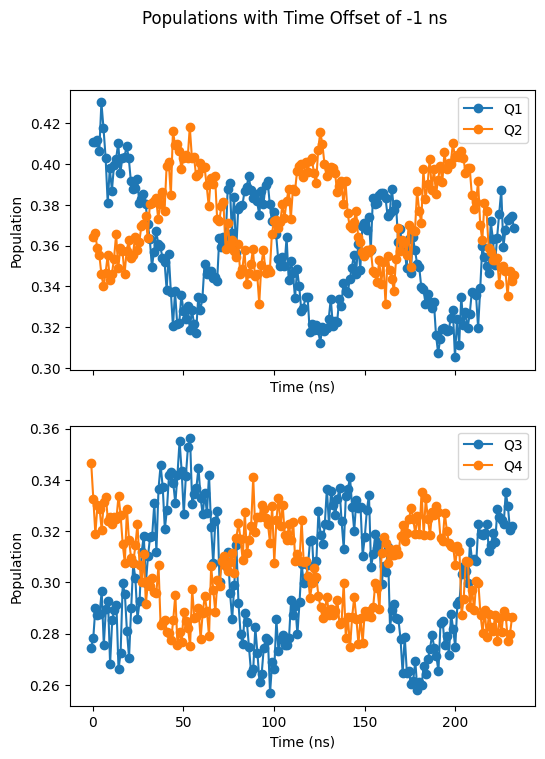

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


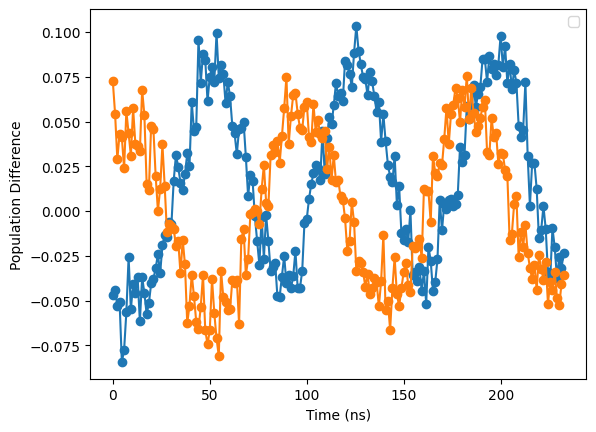

In [91]:
population_shots = measurement.get_population_shots()
print(population_shots.shape)

fig, axs = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
axs = axs.flatten()

axs[0].plot(times, np.mean(population_shots[0], axis=-1), 'o-', label='Q1')
axs[0].plot(times, np.mean(population_shots[1], axis=-1), 'o-', label='Q2')
axs[0].set_xlabel('Time (ns)')
axs[0].set_ylabel('Population')
axs[0].legend()


# offset Q3-Q4 data by some amount
time_offset = -1

axs[1].plot(times + time_offset, np.mean(population_shots[2], axis=-1), 'o-', label='Q3')
axs[1].plot(times + time_offset, np.mean(population_shots[3], axis=-1), 'o-', label='Q4')

axs[1].set_xlabel('Time (ns)')
axs[1].set_ylabel('Population')
axs[1].legend()

plt.suptitle(f'Populations with Time Offset of {time_offset} ns')
plt.show()

q1_q2_difference_shots = population_shots[1, :, :] - population_shots[0, :, :]
q3_q4_difference_shots = population_shots[3, :, :] - population_shots[2, :, :]

plt.plot(times, np.mean(q1_q2_difference_shots, axis=-1), 'o-')
plt.plot(times, np.mean(q3_q4_difference_shots, axis=-1), 'o-')
plt.xlabel('Time (ns)')
plt.ylabel('Population Difference')
plt.legend()
plt.show()


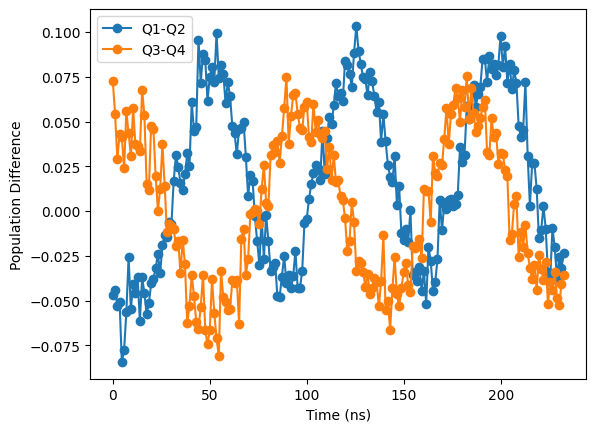

In [103]:
time_offset = 1


time_step = times[1] - times[0]

if time_offset == 0:
    times_padded = times
else:
    times_padded = np.arange(times[0], times[-1] + abs(time_offset), time_step)


if time_offset > 0:
    q1_q2_difference_shots_padded = np.pad(q1_q2_difference_shots, ((0, int(abs(time_offset)/time_step)), (0,0)), mode='constant', constant_values=0)
    q3_q4_difference_shots_padded = np.pad(q3_q4_difference_shots, ((int(abs(time_offset)/time_step), 0), (0,0)), mode='constant', constant_values=0)
elif time_offset < 0:
    q1_q2_difference_shots_padded = np.pad(q1_q2_difference_shots, ((int(abs(time_offset)/time_step), 0), (0,0)), mode='constant', constant_values=0)
    q3_q4_difference_shots_padded = np.pad(q3_q4_difference_shots, ((0, int(abs(time_offset)/time_step)), (0,0)), mode='constant', constant_values=0)
else:
    q1_q2_difference_shots_padded = q1_q2_difference_shots
    q3_q4_difference_shots_padded = q3_q4_difference_shots


plt.plot(times_padded, np.mean(q1_q2_difference_shots_padded, axis=-1), 'o-', label='Q1-Q2')
plt.plot(times_padded, np.mean(q3_q4_difference_shots_padded, axis=-1), 'o-', label='Q3-Q4')
plt.xlabel('Time (ns)')
plt.ylabel('Population Difference')
plt.legend()
plt.show()

Text(0, 0.5, 'Population Difference Product')

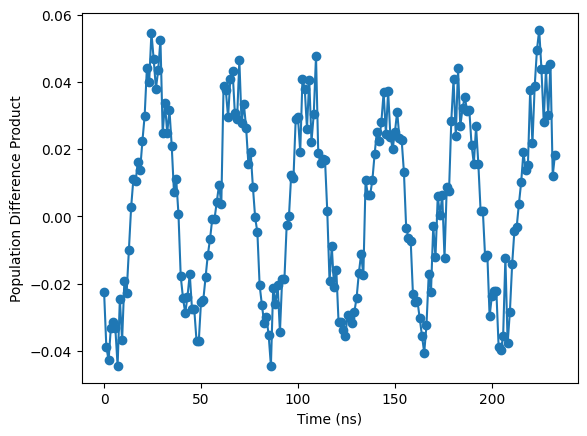

In [104]:
population_difference_product_shots = q1_q2_difference_shots_padded * q3_q4_difference_shots_padded
correlations = np.mean(population_difference_product_shots, axis=-1) - np.mean(q1_q2_difference_shots_padded, axis=-1) * np.mean(q3_q4_difference_shots_padded, axis=-1)

plt.plot(times_padded, correlations, 'o-')
plt.xlabel('Time (ns)')
plt.ylabel('Population Difference Product')

In [94]:
# sweep offset time

time_step = times[1] - times[0]

print(f'initial shape: {q1_q2_difference_shots.shape}')

offset_times_samples = np.arange(-len(times) + 1, len(times) - 1, 1)
max_length = 2*len(times) - 1
print(f'max_length: {max_length}')

correlations = np.zeros((len(offset_times_samples), max_length))

for i in range(len(offset_times_samples)):
    offset_time = offset_times_samples[i]

    if offset_time > 0:
        q1_q2_difference_shots_padded = np.pad(q1_q2_difference_shots, ((0, abs(offset_time)), (0,0)), mode='constant', constant_values=0)
        q3_q4_difference_shots_padded = np.pad(q3_q4_difference_shots, ((abs(offset_time), 0), (0,0)), mode='constant', constant_values=0)
    elif offset_time < 0:
        q1_q2_difference_shots_padded = np.pad(q1_q2_difference_shots, ((abs(offset_time), 0), (0,0)), mode='constant', constant_values=0)
        q3_q4_difference_shots_padded = np.pad(q3_q4_difference_shots, ((0, abs(offset_time)), (0,0)), mode='constant', constant_values=0)
    else:
        q1_q2_difference_shots_padded = q1_q2_difference_shots
        q3_q4_difference_shots_padded = q3_q4_difference_shots

    # center padded arrays within the maximum possible pad length of 2*len(times)-1

    q1_q2_difference_shots_padded_centered = np.zeros((max_length, q1_q2_difference_shots.shape[1]))
    q3_q4_difference_shots_padded_centered = np.zeros((max_length, q3_q4_difference_shots.shape[1]))

    # print(q1_q2_difference_shots_padded.shape)

    start_index = min(i//2, (max_length - i)//2)
    # print(f'start_index: {start_index}')

    q1_q2_difference_shots_padded_centered[start_index:start_index+q1_q2_difference_shots_padded.shape[0], :] = q1_q2_difference_shots_padded
    q3_q4_difference_shots_padded_centered[start_index:start_index+q3_q4_difference_shots_padded.shape[0], :] = q3_q4_difference_shots_padded

    # print(f'length of q1_q2_difference_shots_padded_centered: {q1_q2_difference_shots_padded_centered.shape}')
    # print(f'length of q3_q4_difference_shots_padded_centered: {q3_q4_difference_shots_padded_centered.shape}')


    population_difference_product_shots = q1_q2_difference_shots_padded_centered * q3_q4_difference_shots_padded_centered
    correlations[i, :] = np.mean(population_difference_product_shots, axis=-1) - np.mean(q1_q2_difference_shots_padded_centered, axis=-1) * np.mean(q3_q4_difference_shots_padded_centered, axis=-1)

initial shape: (201, 5000)
max_length: 401


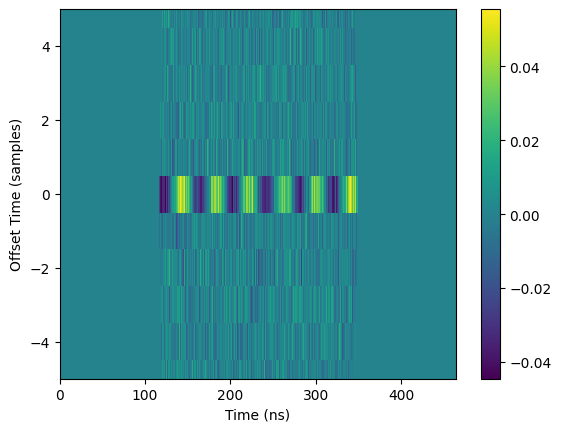

In [95]:
# x_axis = np.arange(0, max_length*time_step, time_step)
x_axis = np.arange(0, max_length, 1) * time_step

# y_axis = offset_times_samples * time_step
y_axis = offset_times_samples

plt.imshow(correlations, aspect='auto', extent=[x_axis[0], x_axis[-1], y_axis[-1], y_axis[0]], interpolation='none')

plt.ylim(-5, 5)

plt.xlabel('Time (ns)')
plt.ylabel('Offset Time (samples)')
plt.colorbar()

plt.show()


In [281]:
state = '3P6Q_1256'
state = '3P6Q_1254'
state = '3P6Q_1234'
state = '4P8Q_1234'
state = '4P8Q_1254'

measurement = state_to_correlation_measurement[state]

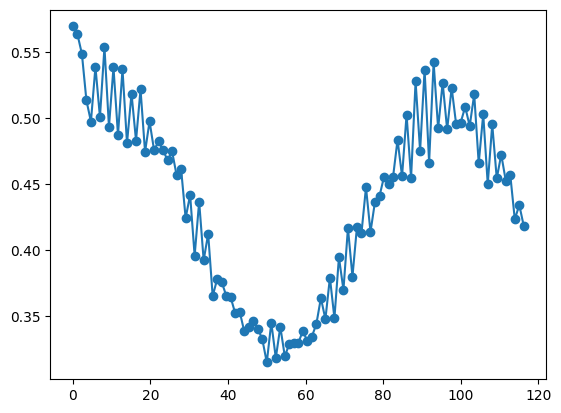

get covariance bitstrings: [(0, 0, 0, 0, 0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 0, 1), (0, 0, 0, 0, 0, 0, 1, 0), (0, 0, 0, 0, 0, 0, 1, 1), (0, 0, 0, 0, 0, 1, 0, 0), (0, 0, 0, 0, 0, 1, 0, 1), (0, 0, 0, 0, 0, 1, 1, 0), (0, 0, 0, 0, 0, 1, 1, 1), (0, 0, 0, 0, 1, 0, 0, 0), (0, 0, 0, 0, 1, 0, 0, 1), (0, 0, 0, 0, 1, 0, 1, 0), (0, 0, 0, 0, 1, 0, 1, 1), (0, 0, 0, 0, 1, 1, 0, 0), (0, 0, 0, 0, 1, 1, 0, 1), (0, 0, 0, 0, 1, 1, 1, 0), (0, 0, 0, 0, 1, 1, 1, 1), (0, 0, 0, 1, 0, 0, 0, 0), (0, 0, 0, 1, 0, 0, 0, 1), (0, 0, 0, 1, 0, 0, 1, 0), (0, 0, 0, 1, 0, 0, 1, 1), (0, 0, 0, 1, 0, 1, 0, 0), (0, 0, 0, 1, 0, 1, 0, 1), (0, 0, 0, 1, 0, 1, 1, 0), (0, 0, 0, 1, 0, 1, 1, 1), (0, 0, 0, 1, 1, 0, 0, 0), (0, 0, 0, 1, 1, 0, 0, 1), (0, 0, 0, 1, 1, 0, 1, 0), (0, 0, 0, 1, 1, 0, 1, 1), (0, 0, 0, 1, 1, 1, 0, 0), (0, 0, 0, 1, 1, 1, 0, 1), (0, 0, 0, 1, 1, 1, 1, 0), (0, 0, 0, 1, 1, 1, 1, 1), (0, 0, 1, 0, 0, 0, 0, 0), (0, 0, 1, 0, 0, 0, 0, 1), (0, 0, 1, 0, 0, 0, 1, 0), (0, 0, 1, 0, 0, 0, 1, 1), (0, 0, 1, 0, 0, 1, 0, 0), (0, 0, 1, 

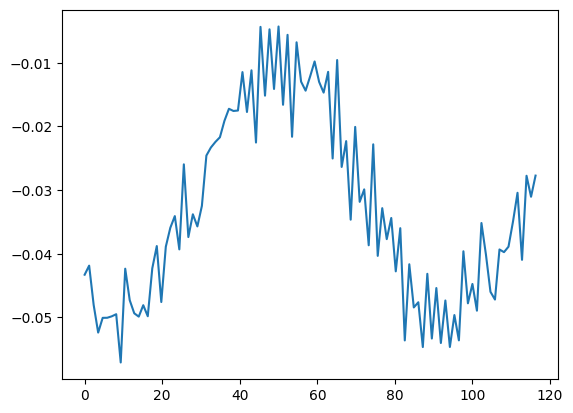

In [282]:
counts = measurement.get_counts()
population = measurement.get_population_average()

times = measurement.get_times()

plt.plot(times, population[0], 'o-')
plt.show()

covariance_data = measurement.get_covariance()

plt.plot(times, covariance_data[0,2])

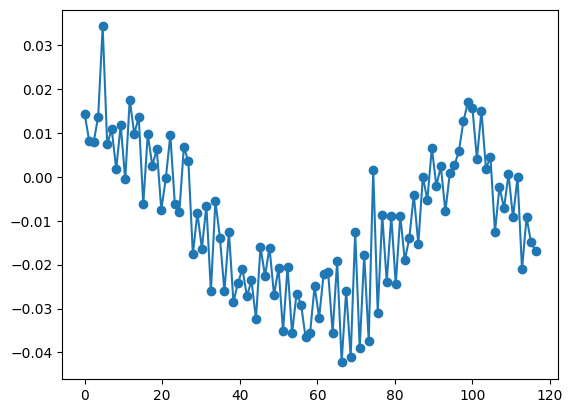

In [283]:
bitstrings = list(product([0,1], repeat=num_qubits))

covariance_count = 0
for i in range(len(bitstrings)):
    if bitstrings[i][0] == 1 and bitstrings[i][2] == 1:
        covariance_count += counts[i, :]

covariance_average = covariance_count/np.sum(counts, axis=0) - population[0]*population[1]

plt.plot(times, covariance_average, 'o-')

In [284]:
### check particle number of counts

bitstrings = list(product([0,1], repeat=8))
counts = measurement.get_counts()

time_index = 0

particle_number_to_count = {}
for i in range(len(counts[:,time_index])):
    # print(f'{bitstrings[i]}: {counts[i,time_index]}')
    particle_number = sum(bitstrings[i])
    if particle_number not in particle_number_to_count:
        particle_number_to_count[particle_number] = 0
    particle_number_to_count[particle_number] += counts[i,time_index]

print(particle_number_to_count)


{0: 14, 1: 214, 2: 1008, 3: 1927, 4: 1523, 5: 284, 6: 29, 7: 1, 8: 0}


207
(256, 101)
num qubits: 8


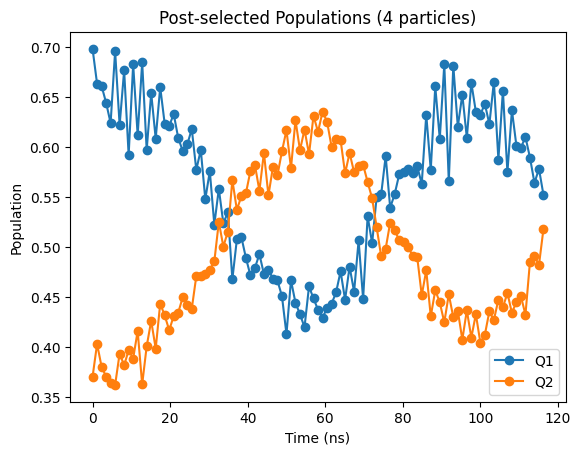

In [290]:
### plot post selected data


post_select = True

print(np.max(counts))

print(counts.shape)

print(f'num qubits: {measurement.get_num_qubits()}')


num_qubits = measurement.get_num_qubits()
num_particles = 4
readout_pair_1 = [0, 1]
# readout_pair_2 = [2, 3]
readout_pair_2 = [4, 3]
# readout_pair_2 = [4, 5]
readout_pair_2 = [6, 5]
# readout_pair_2 = [6, 7]

bitstrings = list(product([0,1], repeat=num_qubits))
bitstrings_n_particles = []

counts_n_particles = []
for i, bitstring in enumerate(bitstrings):
    if sum(bitstring) == num_particles or not post_select:
        bitstrings_n_particles.append(bitstring)
        # print(bitstring)
        counts_n_particles.append(counts[i, :])

counts_n_particles = np.array(counts_n_particles, dtype=float)
counts_n_particles_average = np.array(counts_n_particles, dtype=float)

for j in range(counts_n_particles_average.shape[-1]):
    counts_n_particles_average[:,j] = counts_n_particles_average[:,j] / np.sum(counts_n_particles_average[:,j])


populations_post_selected = np.zeros((num_qubits, counts_n_particles_average.shape[-1]))
for i in range(len(bitstrings_n_particles)):
    for j in range(num_qubits):
        if bitstrings_n_particles[i][j] == 1:
            populations_post_selected[j, :] += counts_n_particles_average[i, :]

total_population = np.sum(populations_post_selected, axis=0)




plot_qubits = [0, 1]
for i in plot_qubits:
    plt.plot(times, populations_post_selected[i, :], 'o-', label=f'Q{i+1}')
    
# plt.plot(times, total_population, '-', color='black', label='Total')
plt.xlabel('Time (ns)')
plt.ylabel('Population')
plt.title(f'Post-selected Populations ({num_particles} particles)')
plt.legend()
plt.show()



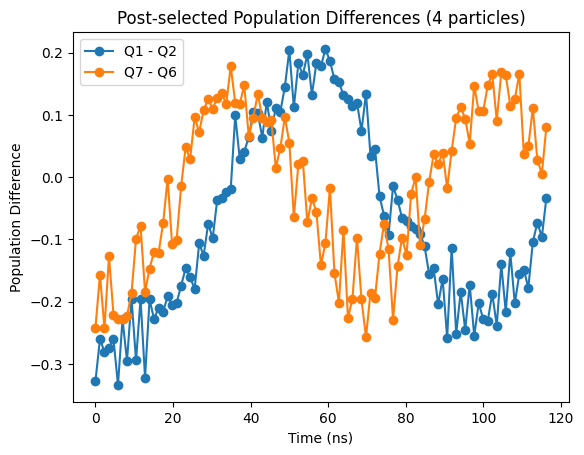

In [291]:
population_differences_post_selected = np.zeros((4, counts_n_particles.shape[-1]))
population_differences_post_selected[0, :] = populations_post_selected[readout_pair_1[1], :] - populations_post_selected[readout_pair_1[0], :]
population_differences_post_selected[1, :] = populations_post_selected[readout_pair_2[1], :] - populations_post_selected[readout_pair_2[0], :]

plt.plot(times, population_differences_post_selected[0, :], 'o-', label=f'Q{readout_pair_1[0]+1} - Q{readout_pair_1[1]+1}')
plt.plot(times, population_differences_post_selected[1, :], 'o-', label=f'Q{readout_pair_2[0]+1} - Q{readout_pair_2[1]+1}')
plt.xlabel('Time (ns)')
plt.ylabel('Population Difference')
plt.title(f'Post-selected Population Differences ({num_particles} particles)')
plt.legend()
plt.show()

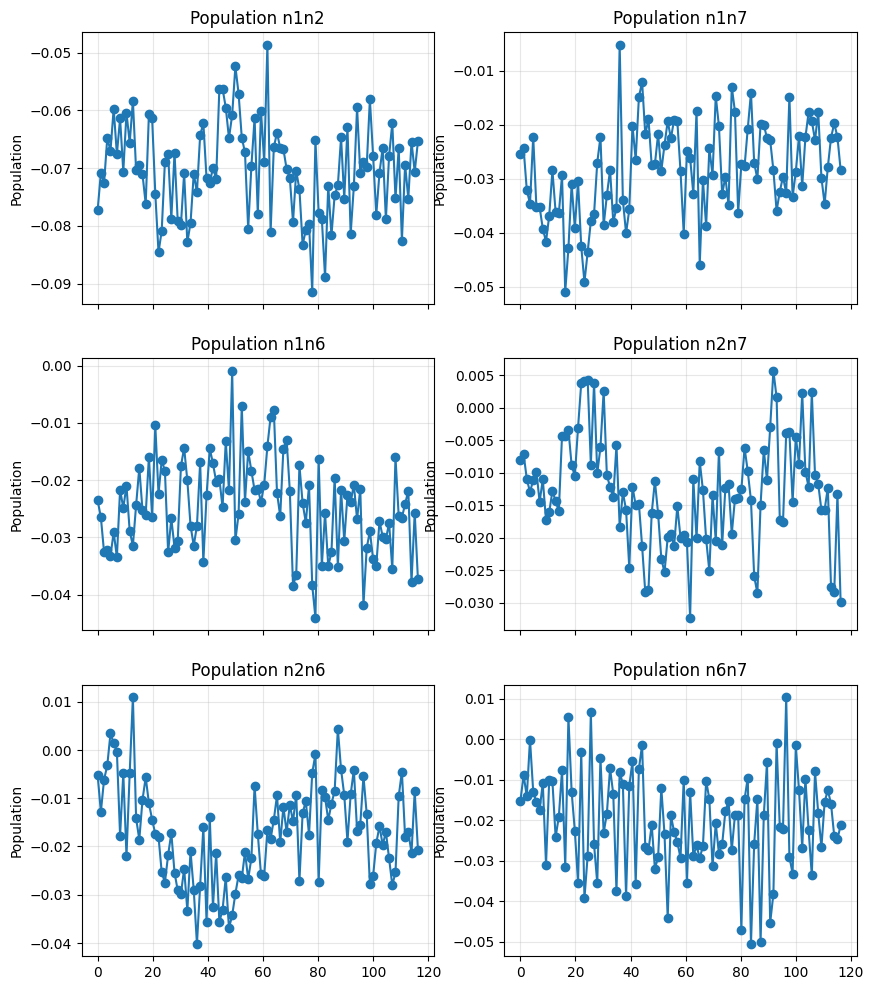

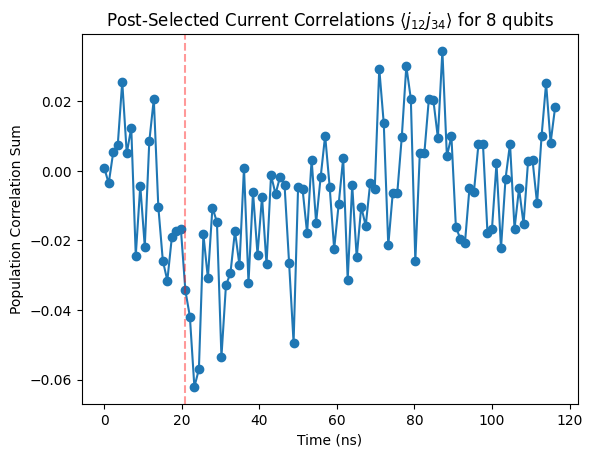

In [292]:
covariance_post_selected = np.zeros((8, 8, counts_n_particles.shape[-1]))

for i in range(len(bitstrings_n_particles)):
    for index_1 in range(covariance_post_selected.shape[0]):
        for index_2 in range(index_1, covariance_post_selected.shape[1]):
            if bitstrings_n_particles[i][index_1] == 1 and bitstrings_n_particles[i][index_2] == 1:
                covariance_post_selected[index_1, index_2, :] += counts_n_particles[i, :]/np.sum(counts_n_particles, axis=0)
            

for i in range(covariance_post_selected.shape[0]):
    for j in range(covariance_post_selected.shape[1]):
        if i == j:
            covariance_post_selected[i, j, :] = populations_post_selected[i, :] * (1 - populations_post_selected[i, :])
        elif i > j:
            covariance_post_selected[i, j, :] = covariance_post_selected[j, i, :]
        else:
            covariance_post_selected[i, j, :] -= populations_post_selected[i, :] * populations_post_selected[j, :]

# n3n4 = covariance_post_selected[2, 3, :]
# n2n4 = covariance_post_selected[1, 3, :]
# n2n3 = covariance_post_selected[1, 2, :]
# n1n4 = covariance_post_selected[0, 3, :]
# n1n3 = covariance_post_selected[0, 2, :]
# n1n2 = covariance_post_selected[0, 1, :]

n3n4 = covariance_post_selected[readout_pair_2[0], readout_pair_2[1], :]
n2n4 = covariance_post_selected[readout_pair_1[1], readout_pair_2[1], :]
n2n3 = covariance_post_selected[readout_pair_1[1], readout_pair_2[0], :]
n1n4 = covariance_post_selected[readout_pair_1[0], readout_pair_2[1], :]
n1n3 = covariance_post_selected[readout_pair_1[0], readout_pair_2[0], :]
n1n2 = covariance_post_selected[readout_pair_1[0], readout_pair_1[1], :]

fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharex=True)
axes = axes.flatten()

n_terms = [n1n2, n1n3, n1n4, n2n3, n2n4, n3n4]

labels = []
for index_1 in readout_pair_1 + readout_pair_2:
    for index_2 in readout_pair_1 + readout_pair_2:
        if index_2 > index_1:
            labels.append(f'n{index_1+1}n{index_2+1}')



for ax, term, label in zip(axes, n_terms, labels):
    ax.plot(times, term, 'o-')
    ax.set_title(f'Population {label}')
    ax.set_ylabel('Population')
    ax.grid(True, alpha=0.3) 

plt.show()


correlation_sum = n1n3 - n1n4 - n2n3 + n2n4

J12 = 6.02*2*np.pi
J34 = 6.01*2*np.pi
J45 = 6.23*2*np.pi
J56 = 6.07*2*np.pi

beamsplitter_time_1234 = abs((np.pi/4)/((J12 + J34)/2))*1e3
beamsplitter_time_1254 = abs((np.pi/4)/((J12 + J45)/2))*1e3
beamsplitter_time_1256 = abs((np.pi/4)/((J12 + J56)/2))*1e3

# print(beamsplitter_time)

plt.plot(times, correlation_sum, 'o-')
plt.xlabel('Time (ns)')
plt.ylabel('Population Correlation Sum')
plt.axvline(beamsplitter_time_1234, color='r', alpha=0.4, linestyle='--', label='Beamsplitter Time')
# plt.title(f'Post-selected Population Correlation Sum ({num_particles} particles)')
plt.title(r'Post-Selected Current Correlations $\langle j_{{12}}j_{{34}} \rangle$ for 8 qubits')
plt.show()

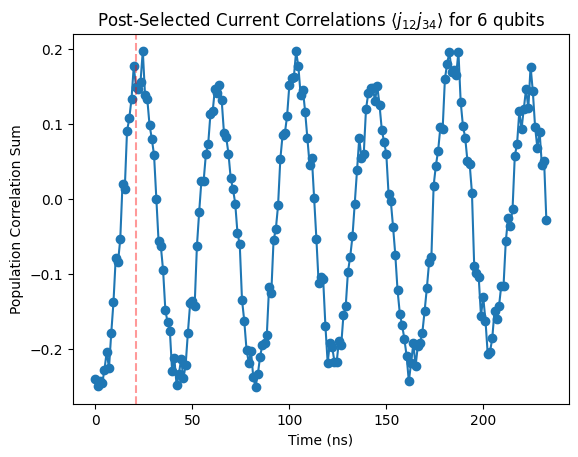
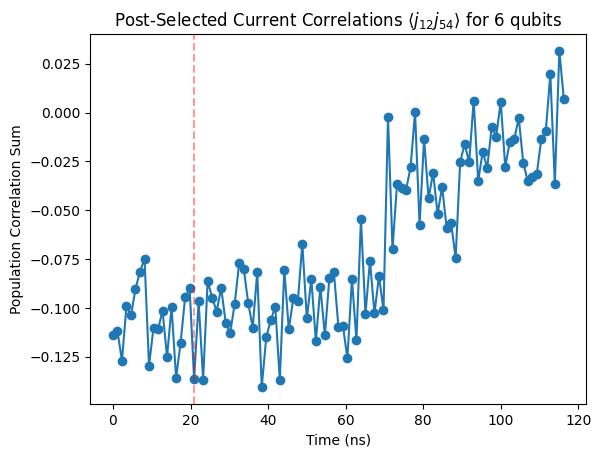
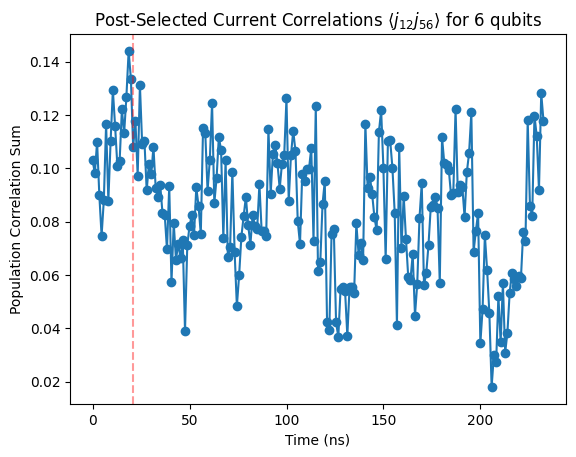

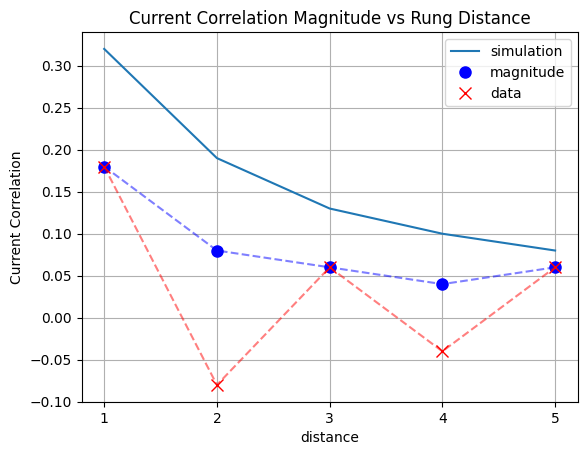

In [293]:
correlations_data = [0.18, -0.08, 0.06, -0.04, 0.06]
expected_correlations = [0.32, -0.19, 0.13, -0.10, 0.08]

distances = [1, 2, 3, 4, 5]

plt.plot(distances, np.abs(expected_correlations), label='simulation')
plt.plot(distances, np.abs(correlations_data), linestyle='', marker='o', color='blue', ms=8, label='magnitude')
plt.plot(distances, np.abs(correlations_data), linestyle='dashed', color='blue', alpha=0.5)
plt.plot(distances, (correlations_data), linestyle='', marker='x', color='red', ms=8, label='data')
plt.plot(distances, (correlations_data), linestyle='dashed', color='red', alpha=0.5)

# plt.xlabel('rung distance')
plt.xticks(ticks=distances, labels=[f'{int(d)}' for d in distances])
plt.xlabel('distance')
plt.ylabel('Current Correlation')

plt.grid()
plt.title('Current Correlation Magnitude vs Rung Distance')


plt.legend()
plt.show()

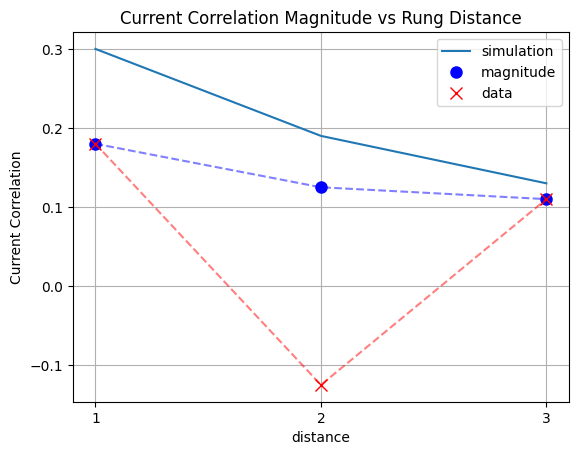

In [216]:
correlations_data = [0.18, -0.125, 0.11]
expected_correlations = [0.3, -0.19, 0.13]

distances = [1, 2, 3]

plt.plot(distances, np.abs(expected_correlations), label='simulation')
plt.plot(distances, np.abs(correlations_data), linestyle='', marker='o', color='blue', ms=8, label='magnitude')
plt.plot(distances, np.abs(correlations_data), linestyle='dashed', color='blue', alpha=0.5)
plt.plot(distances, (correlations_data), linestyle='', marker='x', color='red', ms=8, label='data')
plt.plot(distances, (correlations_data), linestyle='dashed', color='red', alpha=0.5)

# plt.xlabel('rung distance')
plt.xticks(ticks=distances, labels=[f'{int(d)}' for d in distances])
plt.xlabel('distance')
plt.ylabel('Current Correlation')

plt.grid()
plt.title('Current Correlation Magnitude vs Rung Distance')


plt.legend()
plt.show()

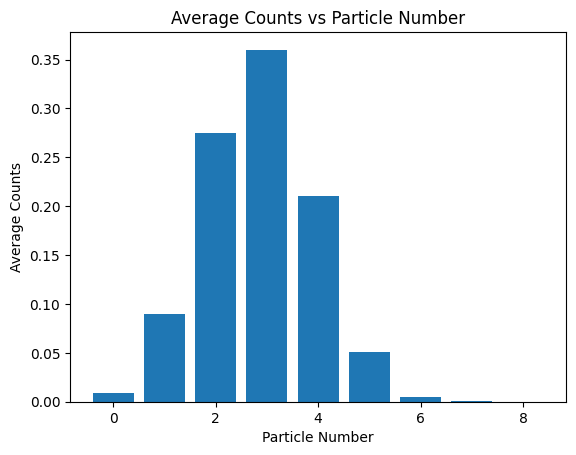

In [217]:
### check what percentage of the measurement had 3 particles


percent_shots_with_n_particles = np.sum(counts_n_particles, axis=0)/np.sum(counts, axis=0)

# plt.plot(times, percent_shots_with_n_particles, 'o-')


particle_number_counts = np.zeros((num_qubits + 1, counts.shape[-1]))

for i in range(len(bitstrings)):
    particle_number = int(np.sum(bitstrings[i]))
    particle_number_counts[particle_number, :] += counts[i, :]/np.sum(counts, axis=0)

# average over time
particle_number_counts_average = np.mean(particle_number_counts, axis=-1)

plt.bar(np.arange(num_qubits + 1), particle_number_counts_average)
plt.xlabel('Particle Number')
plt.ylabel('Average Counts')
plt.title('Average Counts vs Particle Number')
plt.show()

In [306]:

def prob_m_heads(p, m):
    n = len(p)
    probs = np.zeros(n+1)
    # Dynamic programming: probs[m] = probability of m heads
    probs[0] = 1.0
    for i in range(n):
        p_head = p[i]
        p_tail = 1 - p_head
        # Update in reverse to avoid overwriting
        for m in range(i+1, 0, -1):
            probs[m] = probs[m]*p_tail + probs[m-1]*p_head
        probs[0] = probs[0]*p_tail
    return probs

[[0.96 0.1 ]
 [0.04 0.9 ]]
number of 3 particle states: 56
[0.04, 0.04, 0.04, 0.04, 0.04, 0.9, 0.9, 0.9]
2.9
[0.00390625 0.03125    0.109375   0.21875    0.2734375  0.21875
 0.109375   0.03125    0.00390625]


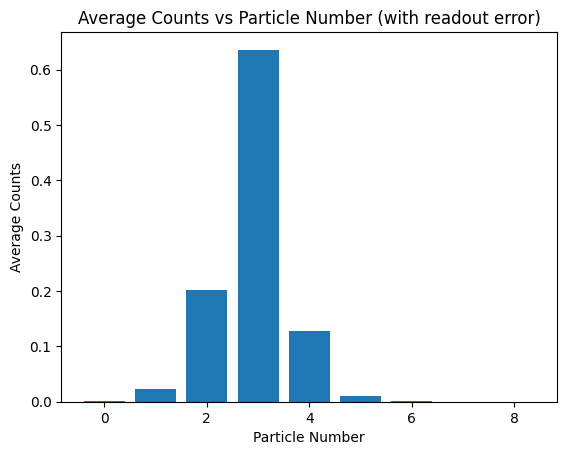

In [ ]:
ng = 0.04
ne = 0.1

confusion_matrix = np.array([[1-ng, ne], 
                             [ng, 1-ne]])

confusion_matrix_inverse = np.linalg.inv(confusion_matrix)

print(confusion_matrix)

# assume a random distribution of n particle states
# compute 8 choose n
# import comb
from scipy.special import comb
num_n_particle_states = int(comb(8, num_particles))

print(f'number of {num_particles} particle states: {num_n_particle_states}')

# create random distribution
random_array = np.random.rand(num_n_particle_states)
random_array /= np.sum(random_array)

# qubit_random_populations = [0]*8
# for i in range(num_n_particle_states):
#     basis_state = bitstrings_n_particles[i]
#     for j in range(8):
#         if basis_state[j] == 1:
#             qubit_random_populations[j] += random_array[i]


particle_number_to_count = {}
for i in range(len(bitstrings_n_particles)):
    basis_state = bitstrings_n_particles[i]
    real_populations = [0]*8
    for j in range(8):
        qubit_state_vector = np.array([1-basis_state[j], basis_state[j]])
        qubit_state_vector_real = confusion_matrix @ qubit_state_vector
        real_populations[j] += qubit_state_vector_real[1]
    pmf = prob_m_heads(real_populations, i)

    break

# real_populations = np.array(real_populations)/num_n_particle_states
print(real_populations)
print(sum(real_populations))
# Suppose p is a length-8 vector of probabilities of heads for each coin
# Compute the probability of getting m heads for each m in 0..8


# Example usage:
p = np.array([0.5]*8)
pmf = prob_m_heads(p, 1)
print(pmf)  # pmf[m] = probability of m heads

particle_number_probabilities = []
pmf = prob_m_heads(real_populations, i)

plt.bar(np.arange(len(pmf)), pmf)
plt.xlabel('Particle Number')
plt.ylabel('Average Counts')
plt.title('Average Counts vs Particle Number (with readout error)')
plt.show()